In [1]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
        
from time import time 
import csv
import pickle
import pylab

import numpy as np
import scipy as sc
import pandas as pd
import editdistance

import torch

import rna
import models
import utils
import vae
import dre
import designers

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('darkgrid')

2024-11-07 22:00:49.399749: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-07 22:00:49.399774: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-07 22:00:49.401018: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 22:00:49.407792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-07 22:00:51.130817: W tensorflow/comp

# train and save model on 10k data points

In [4]:
# train and save models
# need viennaenv kernel for RNA package
reload(rna)
n_train = 10000
p_mutation = 4 / 50
noise_sd = 0.02
n_hidden = 100
n_epoch = 5
lr = 0.001
n_filters = 32
save_fname_no_ftype = 'n{}-nsd{:.2f}-h{}-092324-1'.format(n_train, noise_sd, n_hidden)

ridge, ff, cnn, trainseq_n, ytrain_n, testseq_n, ytest_n = rna.train_models(
    n_train,
    p_mutation=p_mutation,
    noise_sd=noise_sd,
    n_hidden=n_hidden,
    n_epoch=n_epoch,
    lr=lr,
    n_filters=n_filters,
    save_fname_no_ftype=save_fname_no_ftype,
)

Generating 10000 labeled sequences...
Done. (122 s)
Generating 10000 labeled sequences...
Done. (123 s)
CV-selected alpha for ridge: 1.0.
No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.


100%|████████████████████████████████████████| 141/141 [00:01<00:00, 118.70it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.07. 1 sec.


100%|████████████████████████████████████████| 141/141 [00:01<00:00, 117.14it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████| 141/141 [00:01<00:00, 120.55it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████| 141/141 [00:01<00:00, 121.58it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████| 141/141 [00:01<00:00, 111.83it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.
No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 48.74it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.11. 3 sec.


100%|█████████████████████████████████████████| 141/141 [00:03<00:00, 46.02it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 3 sec.


100%|█████████████████████████████████████████| 141/141 [00:03<00:00, 46.72it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 3 sec.


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 56.14it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 2 sec.


100%|█████████████████████████████████████████| 141/141 [00:02<00:00, 47.63it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 3 sec.
Saved models to /data/wongfanc/rna-models/ff-n10000-nsd0.02-h100-092324-1.pt.
Saved FF model to /data/wongfanc/rna-models/ff-n10000-nsd0.02-h100-092324-1.pt.
Saved models to /data/wongfanc/rna-models/cnn-n10000-nsd0.02-h100-092324-1.pt.
Saved CNN model to /data/wongfanc/rna-models/cnn-n10000-nsd0.02-h100-092324-1.pt.
Saved training data to /data/wongfanc/rna-models/traindata-n10000-nsd0.02-h100-092324-1.npz.


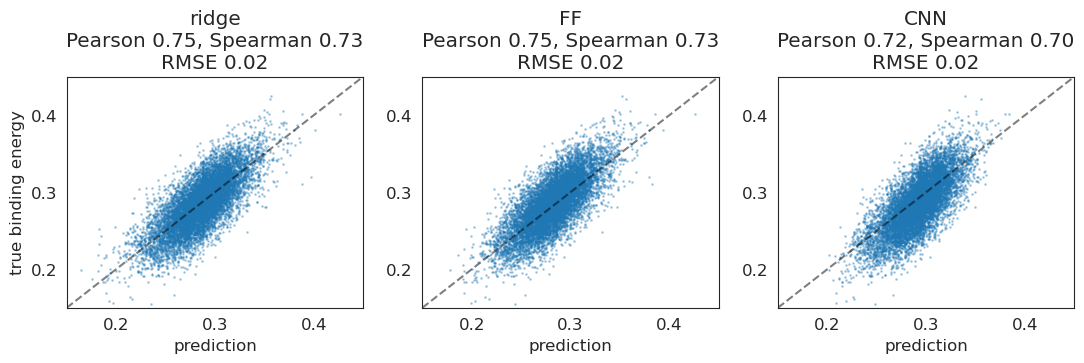

In [5]:
sns.set_style('white')
plt.figure(figsize=(13, 3))
xy_lim = [0.15, 0.45]
model_names = ['ridge', 'FF', 'CNN']

for i, model in enumerate([ridge, ff, cnn]):
    predtest_n = model.predict(testseq_n)
    
    plt.subplot(1, 3, i + 1)
    plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
    plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
    
    r, p = sc.stats.pearsonr(ytest_n, predtest_n)
    rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
    rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))
    
    plt.ylim(xy_lim);
    plt.xlim(xy_lim)
    plt.title('{}\nPearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(model_names[i], r, rho, rmse));
    plt.xlabel('prediction');
    if i == 0: 
        plt.ylabel('true binding energy'); 

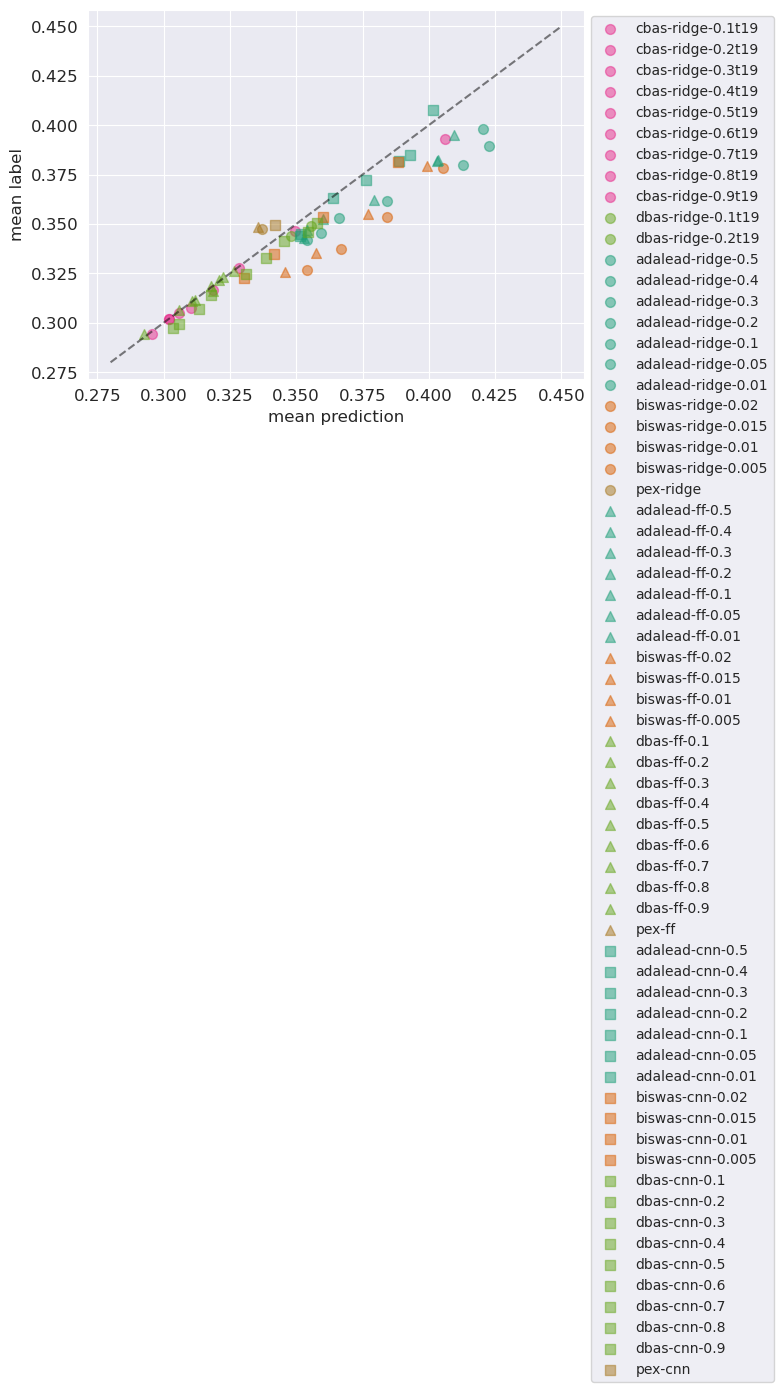

In [7]:
# DEFUNCT AS IS (need to load name2designdata and remove intermediate iterations)
cm = pylab.get_cmap('Dark2')
def name2color(name):
    if 'adalead' in name:
        return cm(0)
    if 'biswas' in name:
        return cm(1 / 5)
    if 'cbas' in name:
        return cm(2 / 5)
    if 'dbas' in name:
        return cm(3 / 5)
    if 'pex' in name:
        return cm(4 / 5)
def name2marker(name):
    if 'ridge' in name:
        return 'o'
    if 'ff' in name:
        return '^'
    if 'cnn' in name:
        return 's'
    
for i, (name, designs) in enumerate(name2designdata.items()):
    seq_n, y_n, pred_n = designs
    if name is not 'train':
        plt.scatter(np.mean(pred_n), np.mean(y_n), label=name, s=50, alpha=0.5, color=name2color(name), marker=name2marker(name))
    
plt.plot([0.28, 0.45], [0.28, 0.45], '--k', alpha=0.5)
plt.xlabel('mean prediction');
plt.ylabel('mean label');
plt.legend(bbox_to_anchor=(1, 1), fontsize=10);

# sample and label designs, multiple trials

10.02: sample from 5k models for PP designs (CbAS FF, CNN and training data VAE)

In [2]:
reload(models)
reload(rna)
reload(designers)

n_design = 50000
cbas_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_and_data_fname_no_ftype = 'nsd0.02-040324'
model_and_data_path = '/data/wongfanc/rna-models'
design_pkl_fname = '/data/wongfanc/rna-results/designs-n5k-cbas-100224.pkl'

# ===== copied from sample_design_sequences() =====

data_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

ridge = models.RidgeRegressor(seq_len=50, alphabet=utils.RNA_NUCLEOTIDES)
ridge.fit(trainseq_n, ytrain_n)

# load trained FF and CNN models
ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, utils.RNA_NUCLEOTIDES, 100)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, utils.RNA_NUCLEOTIDES, 32, 100)
cnn.load(cnn_fname)

name2model = {
    'ff': ff,
    'cnn': cnn
}

# design sequences
name2designs = {}


# ----- CbAS with other models, no intermediate iterations -----
for model_name, model in name2model.items():
    if model_name != 'ridge':
        cbas = designers.CbAS(
            model,
            trainseq_n,
            latent_dim=10,
            n_hidden=20,
            weight_type='cbas',
            device='cuda'
        )
        for quantile in cbas_quantiles:
            quantile = round(quantile, 2)

            # design sequences
            print(f'Designing CbAS {quantile} {model_name} sequences...')
            t0 = time()
            cbas_n = cbas.design_sequences(
                n_design,
                quantile=quantile
            )
            print(f'  Done. ({int(time() - t0)} s)')

            # store
            predcbas_n = model.predict(cbas_n)
            print('  Mean prediction: {:.3f}'.format(np.mean(predcbas_n)))
            name2designs[f'cbas-{model_name}-{quantile}'] = (cbas_n, None, predcbas_n)

            # save
            with open(design_pkl_fname, 'wb') as f:
                pickle.dump(name2designs, f)
            print(f'  Saved {n_design} CbAS {quantile} {model_name} sequences to {design_pkl_fname}.\n')

# sample from VAE fit to training sequences
print(f'Designing sequences from training distribution...')
t0 = time()
trainvae_n = cbas.sample_from_train_distribution(n_design)
print(f'  Done. ({int(time() - t0)} s)')

# store
predtrainvae_n = ridge.predict(trainvae_n)
print('  Mean prediction: {:.3f}'.format(np.mean(predtrainvae_n)))
name2designs['vae'] = (trainvae_n, None, predtrainvae_n)

# save
with open(design_pkl_fname, 'wb') as f:
    pickle.dump(name2designs, f)
print(f'  Saved {n_design} training VAE sequences to {design_pkl_fname}.')

Loaded 5000 training points from /data/wongfanc/rna-models/traindata-nsd0.02-040324.npz.

Fitting training distribution to initialize CbAS:
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.
Epoch 0. Train loss: 22.1167, KL: 0.7407, CE: 21.3760. Val loss: 70.9372, KL: 0.0817, CE: 70.8555. (2 s)
Epoch 1. Train loss: 14.9018, KL: 0.0278, CE: 14.8739. Val loss: 15.2559, KL: 0.0138, CE: 15.2422. (1 s)
Epoch 2. Train loss: 14.7237, KL: 0.0707, CE: 14.6531. Val loss: 14.9746, KL: 0.0540, CE: 14.9207. (2 s)
Epoch 3. Train loss: 14.6771, KL: 0.0676, CE: 14.6095. Val loss: 14.9322, KL: 0.0716, CE: 14.8607. (1 s)
Epoch 4. Train loss: 14.6655, KL: 0.0583, CE: 14.6072. Val loss: 14.8200, KL: 0.0649, CE: 14.7551. (1 s)
Designing CbAS 0.1 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.1:
Iter 0. Mean, SD, max prediction: 0.284, 0.023, 0.361. 1000 valid samples for threshold 0.254. (3 s)
Iter 1. Mean, SD, max

Iter 5. Mean, SD, max prediction: 0.290, 0.025, 0.425. 1000 valid samples for threshold 0.284. (22 s)
Iter 6. Mean, SD, max prediction: 0.291, 0.024, 0.382. 1000 valid samples for threshold 0.286. (26 s)
Iter 7. Mean, SD, max prediction: 0.290, 0.024, 0.375. 1000 valid samples for threshold 0.286. (30 s)
Iter 8. Mean, SD, max prediction: 0.291, 0.025, 0.373. 1000 valid samples for threshold 0.287. (33 s)
Iter 9. Mean, SD, max prediction: 0.290, 0.022, 0.362. 1000 valid samples for threshold 0.287. (37 s)
Iter 10. Mean, SD, max prediction: 0.289, 0.024, 0.371. 1000 valid samples for threshold 0.287. (40 s)
Iter 11. Mean, SD, max prediction: 0.291, 0.023, 0.398. 1000 valid samples for threshold 0.287. (43 s)
Iter 12. Mean, SD, max prediction: 0.291, 0.023, 0.401. 1000 valid samples for threshold 0.287. (47 s)
Iter 13. Mean, SD, max prediction: 0.289, 0.025, 0.380. 1000 valid samples for threshold 0.287. (51 s)
Iter 14. Mean, SD, max prediction: 0.288, 0.022, 0.358. 1000 valid samples for

Iter 19. Mean, SD, max prediction: 0.291, 0.023, 0.360. 1000 valid samples for threshold 0.304. (75 s)
  Done. (85 s)
  Mean prediction: 0.291
  Saved 50000 CbAS 0.7 ff sequences to /data/wongfanc/rna-results/designs-n5k-cbas-100224.pkl.

Designing CbAS 0.8 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.8:
Iter 0. Mean, SD, max prediction: 0.284, 0.024, 0.357. 1000 valid samples for threshold 0.302. (3 s)
Iter 1. Mean, SD, max prediction: 0.284, 0.024, 0.373. 1000 valid samples for threshold 0.303. (7 s)
Iter 2. Mean, SD, max prediction: 0.289, 0.024, 0.369. 1000 valid samples for threshold 0.306. (11 s)
Iter 3. Mean, SD, max prediction: 0.290, 0.026, 0.386. 1000 valid samples for threshold 0.309. (14 s)
Iter 4. Mean, SD, max prediction: 0.291, 0.024, 0.387. 1000 valid samples for threshold 0.310. (18 s)
Iter 5. Mean, SD, max prediction: 0.290, 0.023, 0.373. 1000 valid samples for threshold 0.310. (22 s)
Iter 6. Mean, SD, max prediction: 0.291, 0.023, 0.36

Iter 4. Mean, SD, max prediction: 0.289, 0.020, 0.358. 1000 valid samples for threshold 0.275. (19 s)
Iter 5. Mean, SD, max prediction: 0.288, 0.020, 0.359. 1000 valid samples for threshold 0.275. (23 s)
Iter 6. Mean, SD, max prediction: 0.289, 0.020, 0.355. 1000 valid samples for threshold 0.275. (26 s)
Iter 7. Mean, SD, max prediction: 0.289, 0.021, 0.362. 1000 valid samples for threshold 0.275. (30 s)
Iter 8. Mean, SD, max prediction: 0.288, 0.021, 0.373. 1000 valid samples for threshold 0.275. (34 s)
Iter 9. Mean, SD, max prediction: 0.287, 0.020, 0.352. 1000 valid samples for threshold 0.275. (38 s)
Iter 10. Mean, SD, max prediction: 0.288, 0.020, 0.356. 1000 valid samples for threshold 0.275. (41 s)
Iter 11. Mean, SD, max prediction: 0.288, 0.020, 0.354. 1000 valid samples for threshold 0.275. (46 s)
Iter 12. Mean, SD, max prediction: 0.288, 0.020, 0.361. 1000 valid samples for threshold 0.275. (50 s)
Iter 13. Mean, SD, max prediction: 0.287, 0.020, 0.350. 1000 valid samples for 

Iter 18. Mean, SD, max prediction: 0.288, 0.020, 0.361. 1000 valid samples for threshold 0.289. (69 s)
Iter 19. Mean, SD, max prediction: 0.288, 0.019, 0.350. 1000 valid samples for threshold 0.289. (73 s)
  Done. (83 s)
  Mean prediction: 0.288
  Saved 50000 CbAS 0.5 cnn sequences to /data/wongfanc/rna-results/designs-n5k-cbas-100224.pkl.

Designing CbAS 0.6 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.6:
Iter 0. Mean, SD, max prediction: 0.284, 0.020, 0.347. 1000 valid samples for threshold 0.289. (3 s)
Iter 1. Mean, SD, max prediction: 0.284, 0.020, 0.364. 1000 valid samples for threshold 0.289. (7 s)
Iter 2. Mean, SD, max prediction: 0.288, 0.020, 0.357. 1000 valid samples for threshold 0.292. (11 s)
Iter 3. Mean, SD, max prediction: 0.288, 0.020, 0.354. 1000 valid samples for threshold 0.293. (15 s)
Iter 4. Mean, SD, max prediction: 0.289, 0.019, 0.354. 1000 valid samples for threshold 0.293. (19 s)
Iter 5. Mean, SD, max prediction: 0.288, 0.019, 0

Iter 9. Mean, SD, max prediction: 0.290, 0.017, 0.345. 1000 valid samples for threshold 0.314. (38 s)
Iter 10. Mean, SD, max prediction: 0.291, 0.018, 0.355. 1000 valid samples for threshold 0.314. (42 s)
Iter 11. Mean, SD, max prediction: 0.290, 0.018, 0.342. 1000 valid samples for threshold 0.314. (46 s)
Iter 12. Mean, SD, max prediction: 0.290, 0.020, 0.357. 1000 valid samples for threshold 0.315. (50 s)
Iter 13. Mean, SD, max prediction: 0.290, 0.020, 0.347. 1000 valid samples for threshold 0.315. (54 s)
Iter 14. Mean, SD, max prediction: 0.290, 0.020, 0.352. 1000 valid samples for threshold 0.316. (58 s)
Iter 15. Mean, SD, max prediction: 0.291, 0.019, 0.363. 1000 valid samples for threshold 0.316. (62 s)
Iter 16. Mean, SD, max prediction: 0.291, 0.019, 0.362. 1000 valid samples for threshold 0.316. (66 s)
Iter 17. Mean, SD, max prediction: 0.291, 0.020, 0.362. 1000 valid samples for threshold 0.316. (70 s)
Iter 18. Mean, SD, max prediction: 0.291, 0.020, 0.362. 1000 valid samples

In [2]:
# label (need viennaenv)
design_pkl_fname = '/data/wongfanc/rna-results/designs-n5k-cbas-100224.pkl'
rna.label_design_sequences(design_pkl_fname)

Using landscape with binding target 0, seed sequence 3, and noise SD 0.02.
Loading/saving labeled name2designdata to /data/wongfanc/rna-results/designs-n5k-cbas-100224.pkl
Getting labels for cbas-ff-0.1...
  Mean prediction: 0.288, mean label: 0.289. (614 s)

Getting labels for cbas-ff-0.2...
  Mean prediction: 0.290, mean label: 0.291. (1229 s)

Getting labels for cbas-ff-0.3...
  Mean prediction: 0.290, mean label: 0.292. (1844 s)

Getting labels for cbas-ff-0.4...
  Mean prediction: 0.289, mean label: 0.290. (2460 s)

Getting labels for cbas-ff-0.5...
  Mean prediction: 0.290, mean label: 0.291. (3075 s)

Getting labels for cbas-ff-0.6...
  Mean prediction: 0.290, mean label: 0.291. (3690 s)

Getting labels for cbas-ff-0.7...
  Mean prediction: 0.291, mean label: 0.292. (4306 s)

Getting labels for cbas-ff-0.8...
  Mean prediction: 0.292, mean label: 0.294. (4922 s)

Getting labels for cbas-ff-0.9...
  Mean prediction: 0.294, mean label: 0.295. (5538 s)

Getting labels for cbas-cnn-

In [11]:
# stitch back together
design_pkl_fname1 = '/data/wongfanc/rna-results/designs-041124.pkl'
with open(design_pkl_fname1, 'rb') as f1:
    name2designdata1 = pickle.load(f1)
    
design_pkl_fname2 = '/data/wongfanc/rna-results/designs-n5k-cbas-100224.pkl'
with open(design_pkl_fname2, 'rb') as f2:
    name2designdata2 = pickle.load(f2)

name2designdata1.update(name2designdata2)

In [ ]:
# verify
for name in name2designdata1:
    print(name)

In [13]:
# save stitched design data
design_pkl_fname1 = '/data/wongfanc/rna-results/designs-041124.pkl'
with open(design_pkl_fname1, 'wb') as f1:
    pickle.dump(name2designdata1, f1)

sample from 10k models for imputation designs

In [ ]:
# torchenv here, change to viennaenv in next cell for labeling
reload(models)
reload(rna)

n_trial = 10
n_design = 50000
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
dbas_quantiles = [0.1, 0.2]
model_and_data_fname_no_ftype = 'n10000-nsd0.02-h100-092324'

for i in range(3, n_trial):
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-{}.pkl'.format(i)
    name2designs = rna.sample_design_sequences(
        n_design,
        adalead_thresholds,
        biswas_temperatures,
        cbas_quantiles,
        dbas_quantiles,
        intermediate_iter=[19],
        model_and_data_fname_no_ftype=model_and_data_fname_no_ftype,
        design_pkl_fname=design_pkl_fname
    )

Loaded 10000 training points from /data/wongfanc/rna-models/traindata-n10000-nsd0.02-h100-092324.npz.

Saving all results to /data/wongfanc/rna-results/designs-n10k-092324-3.pkl.

Fitting training distribution to initialize CbAS:
One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.
Epoch 0. Train loss: 18.2248, KL: 0.5181, CE: 17.7066. Val loss: 70.1844, KL: 0.1264, CE: 70.0580. (4 s)
Epoch 1. Train loss: 14.7626, KL: 0.0158, CE: 14.7468. Val loss: 14.4913, KL: 0.0113, CE: 14.4800. (3 s)
Epoch 2. Train loss: 14.7178, KL: 0.0242, CE: 14.6935. Val loss: 14.4280, KL: 0.0216, CE: 14.4064. (4 s)
Epoch 3. Train loss: 14.7019, KL: 0.0252, CE: 14.6766. Val loss: 14.4117, KL: 0.0222, CE: 14.3895. (7 s)
Epoch 4. Train loss: 14.6971, KL: 0.0221, CE: 14.6750. Val loss: 14.3733, KL: 0.0219, CE: 14.3514. (4 s)
Designing CbAS 0.1 ridge sequences from intermediate iterations [19]...
Fitting design distribution with quantile hyperparameter 

Iter 1. Mean, SD, max prediction: 0.296, 0.024, 0.395. 1000 valid samples for threshold 0.290. (9 s)
Iter 2. Mean, SD, max prediction: 0.300, 0.024, 0.396. 1000 valid samples for threshold 0.293. (14 s)
Iter 3. Mean, SD, max prediction: 0.301, 0.024, 0.393. 1000 valid samples for threshold 0.293. (18 s)
Iter 4. Mean, SD, max prediction: 0.302, 0.024, 0.392. 1000 valid samples for threshold 0.293. (23 s)
Iter 5. Mean, SD, max prediction: 0.302, 0.024, 0.383. 1000 valid samples for threshold 0.295. (26 s)
Iter 6. Mean, SD, max prediction: 0.303, 0.024, 0.383. 1000 valid samples for threshold 0.297. (30 s)
Iter 7. Mean, SD, max prediction: 0.304, 0.025, 0.408. 1000 valid samples for threshold 0.297. (34 s)
Iter 8. Mean, SD, max prediction: 0.306, 0.026, 0.408. 1000 valid samples for threshold 0.298. (38 s)
Iter 9. Mean, SD, max prediction: 0.304, 0.025, 0.390. 1000 valid samples for threshold 0.298. (43 s)
Iter 10. Mean, SD, max prediction: 0.306, 0.025, 0.409. 1000 valid samples for thre

Iter 12. Mean, SD, max prediction: 0.329, 0.030, 0.464. 1000 valid samples for threshold 0.343. (63 s)
Iter 13. Mean, SD, max prediction: 0.331, 0.030, 0.468. 1000 valid samples for threshold 0.346. (68 s)
Iter 14. Mean, SD, max prediction: 0.330, 0.030, 0.462. 1000 valid samples for threshold 0.346. (73 s)
Iter 15. Mean, SD, max prediction: 0.329, 0.030, 0.437. 1000 valid samples for threshold 0.346. (77 s)
Iter 16. Mean, SD, max prediction: 0.332, 0.030, 0.448. 1000 valid samples for threshold 0.346. (82 s)
Iter 17. Mean, SD, max prediction: 0.329, 0.029, 0.450. 1000 valid samples for threshold 0.346. (87 s)
Iter 18. Mean, SD, max prediction: 0.328, 0.029, 0.434. 1000 valid samples for threshold 0.346. (91 s)
Iter 19. Mean, SD, max prediction: 0.331, 0.030, 0.469. 1000 valid samples for threshold 0.346. (96 s)
  Done. (96 s)
Designing sequences from quantile = 0.700, iteration 19 / 19...
  Done. (10 s)
  Done. (106 s)
  Mean prediction for iteration 19: 0.332
  Saved 50000 CbAS 0.7 t

Iter 14. Mean, SD, max prediction: 0.305, 0.023, 0.393. 1000 valid samples for threshold 0.279. (74 s)
Iter 15. Mean, SD, max prediction: 0.307, 0.022, 0.397. 1000 valid samples for threshold 0.282. (79 s)
Iter 16. Mean, SD, max prediction: 0.313, 0.025, 0.424. 1000 valid samples for threshold 0.285. (83 s)
Iter 17. Mean, SD, max prediction: 0.313, 0.024, 0.436. 1000 valid samples for threshold 0.287. (88 s)
Iter 18. Mean, SD, max prediction: 0.319, 0.025, 0.418. 1000 valid samples for threshold 0.288. (93 s)
Iter 19. Mean, SD, max prediction: 0.324, 0.027, 0.444. 1000 valid samples for threshold 0.291. (97 s)
  Done. (97 s)
Designing sequences from quantile = 0.100, iteration 19 / 19...
  Done. (10 s)
  Done. (108 s)
  Mean prediction for iteration 19: 0.324
  Saved 50000 DbAS 0.1 t = 19 ridge sequences.

Designing DbAS 0.2 ridge sequences from intermediate iterations [19]...
Fitting design distribution with quantile hyperparameter = 0.2:
Iter 0. Mean, SD, max prediction: 0.286, 0.026

Iter 0. Mean, SD, max prediction: 0.286, 0.027, 0.383. 1000 valid samples for threshold 0.253. (3 s)
Iter 1. Mean, SD, max prediction: 0.291, 0.025, 0.381. 1000 valid samples for threshold 0.260. (9 s)
Iter 2. Mean, SD, max prediction: 0.291, 0.025, 0.373. 1000 valid samples for threshold 0.260. (16 s)
Iter 3. Mean, SD, max prediction: 0.295, 0.024, 0.384. 1000 valid samples for threshold 0.266. (20 s)
Iter 4. Mean, SD, max prediction: 0.297, 0.024, 0.423. 1000 valid samples for threshold 0.269. (24 s)
Iter 5. Mean, SD, max prediction: 0.296, 0.024, 0.381. 1000 valid samples for threshold 0.269. (30 s)
Iter 6. Mean, SD, max prediction: 0.301, 0.023, 0.395. 1000 valid samples for threshold 0.273. (36 s)
Iter 7. Mean, SD, max prediction: 0.302, 0.023, 0.395. 1000 valid samples for threshold 0.275. (40 s)
Iter 8. Mean, SD, max prediction: 0.301, 0.023, 0.403. 1000 valid samples for threshold 0.275. (44 s)
Iter 9. Mean, SD, max prediction: 0.302, 0.022, 0.402. 1000 valid samples for thresh

Iter 15. Mean, SD, max prediction: 0.539, 0.043, 0.690. 998 valid samples for threshold 0.528. (74 s)
Iter 16. Mean, SD, max prediction: 0.563, 0.044, 0.707. 995 valid samples for threshold 0.552. (78 s)
Iter 17. Mean, SD, max prediction: 0.589, 0.040, 0.702. 998 valid samples for threshold 0.580. (83 s)
Iter 18. Mean, SD, max prediction: 0.613, 0.041, 0.767. 998 valid samples for threshold 0.604. (89 s)
Iter 19. Mean, SD, max prediction: 0.633, 0.039, 0.750. 1000 valid samples for threshold 0.624. (94 s)
  Done. (105 s)
  Mean prediction: 0.641
  Saved 50000 CbAS 0.4 ff sequences.

Designing CbAS 0.5 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.5:
Iter 0. Mean, SD, max prediction: 0.285, 0.025, 0.361. 1000 valid samples for threshold 0.286. (5 s)
Iter 1. Mean, SD, max prediction: 0.295, 0.024, 0.387. 1000 valid samples for threshold 0.293. (9 s)
Iter 2. Mean, SD, max prediction: 0.307, 0.025, 0.393. 1000 valid samples for threshold 0.307. (14 s)
Iter 3.

Iter 9. Mean, SD, max prediction: 0.635, 0.043, 0.767. 964 valid samples for threshold 0.670. (46 s)
Iter 10. Mean, SD, max prediction: 0.684, 0.039, 0.794. 968 valid samples for threshold 0.716. (50 s)
Iter 11. Mean, SD, max prediction: 0.723, 0.033, 0.825. 993 valid samples for threshold 0.752. (55 s)
Iter 12. Mean, SD, max prediction: 0.754, 0.028, 0.828. 1000 valid samples for threshold 0.778. (60 s)
Iter 13. Mean, SD, max prediction: 0.779, 0.024, 0.838. 998 valid samples for threshold 0.800. (67 s)
Iter 14. Mean, SD, max prediction: 0.798, 0.020, 0.849. 1000 valid samples for threshold 0.816. (71 s)
Iter 15. Mean, SD, max prediction: 0.814, 0.017, 0.854. 1000 valid samples for threshold 0.828. (76 s)
Iter 16. Mean, SD, max prediction: 0.824, 0.015, 0.859. 1000 valid samples for threshold 0.837. (82 s)
Iter 17. Mean, SD, max prediction: 0.833, 0.012, 0.862. 1000 valid samples for threshold 0.843. (88 s)
Iter 18. Mean, SD, max prediction: 0.839, 0.011, 0.863. 1000 valid samples for

Iter 18. Mean, SD, max prediction: 0.308, 0.026, 0.424. 1000 valid samples for threshold 0.286. (98 s)
Iter 19. Mean, SD, max prediction: 0.308, 0.026, 0.421. 1000 valid samples for threshold 0.287. (103 s)
  Done. (114 s)
  Mean prediction: 0.307
  Saved 50000 DbAS 0.2 ff sequences.

Designing DbAS 0.3 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.3:
Iter 0. Mean, SD, max prediction: 0.288, 0.024, 0.379. 1000 valid samples for threshold 0.276. (5 s)
Iter 1. Mean, SD, max prediction: 0.286, 0.025, 0.385. 1000 valid samples for threshold 0.276. (11 s)
Iter 2. Mean, SD, max prediction: 0.286, 0.025, 0.367. 1000 valid samples for threshold 0.276. (16 s)
Iter 3. Mean, SD, max prediction: 0.290, 0.025, 0.386. 1000 valid samples for threshold 0.278. (21 s)
Iter 4. Mean, SD, max prediction: 0.289, 0.025, 0.378. 1000 valid samples for threshold 0.278. (27 s)
Iter 5. Mean, SD, max prediction: 0.289, 0.024, 0.384. 1000 valid samples for threshold 0.278. (31 s)
Iter

Iter 11. Mean, SD, max prediction: 0.305, 0.026, 0.391. 1000 valid samples for threshold 0.309. (66 s)
Iter 12. Mean, SD, max prediction: 0.304, 0.026, 0.407. 1000 valid samples for threshold 0.309. (71 s)
Iter 13. Mean, SD, max prediction: 0.307, 0.026, 0.389. 1000 valid samples for threshold 0.311. (77 s)
Iter 14. Mean, SD, max prediction: 0.307, 0.028, 0.433. 1000 valid samples for threshold 0.311. (82 s)
Iter 15. Mean, SD, max prediction: 0.307, 0.028, 0.407. 1000 valid samples for threshold 0.311. (88 s)
Iter 16. Mean, SD, max prediction: 0.307, 0.028, 0.406. 1000 valid samples for threshold 0.312. (94 s)
Iter 17. Mean, SD, max prediction: 0.308, 0.027, 0.396. 1000 valid samples for threshold 0.314. (98 s)
Iter 18. Mean, SD, max prediction: 0.308, 0.029, 0.407. 1000 valid samples for threshold 0.314. (105 s)
Iter 19. Mean, SD, max prediction: 0.308, 0.027, 0.404. 1000 valid samples for threshold 0.314. (111 s)
  Done. (121 s)
  Mean prediction: 0.308
  Saved 50000 DbAS 0.6 ff sequ

  Saved 50000 AdaLead threshold = 0.35 ff sequences.

Designing AdaLead threshold = 0.3 ff sequences...
  Done. (74 s)
  Mean prediction: 0.375
  Saved 50000 AdaLead threshold = 0.3 ff sequences.

Designing AdaLead threshold = 0.25 ff sequences...
  Done. (73 s)
  Mean prediction: 0.378
  Saved 50000 AdaLead threshold = 0.25 ff sequences.

Designing AdaLead threshold = 0.2 ff sequences...
  Done. (70 s)
  Mean prediction: 0.386
  Saved 50000 AdaLead threshold = 0.2 ff sequences.

Designing AdaLead threshold = 0.15 ff sequences...
  Done. (75 s)
  Mean prediction: 0.394
  Saved 50000 AdaLead threshold = 0.15 ff sequences.

Designing AdaLead threshold = 0.1 ff sequences...
  Done. (84 s)
  Mean prediction: 0.403
  Saved 50000 AdaLead threshold = 0.1 ff sequences.

Designing AdaLead threshold = 0.05 ff sequences...
  Done. (112 s)
  Mean prediction: 0.408
  Saved 50000 AdaLead threshold = 0.05 ff sequences.

Designing AdaLead threshold = 0.01 ff sequences...
  Done. (167 s)
  Mean predict

Iter 16. Mean, SD, max prediction: 0.308, 0.026, 0.436. 1000 valid samples for threshold 0.287. (64 s)
Iter 17. Mean, SD, max prediction: 0.313, 0.028, 0.440. 1000 valid samples for threshold 0.289. (68 s)
Iter 18. Mean, SD, max prediction: 0.311, 0.027, 0.423. 1000 valid samples for threshold 0.289. (72 s)
Iter 19. Mean, SD, max prediction: 0.312, 0.028, 0.417. 1000 valid samples for threshold 0.289. (76 s)
  Done. (86 s)
  Mean prediction: 0.318
  Saved 50000 CbAS 0.2 cnn sequences.

Designing CbAS 0.3 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.3:
Iter 0. Mean, SD, max prediction: 0.286, 0.026, 0.382. 1000 valid samples for threshold 0.275. (3 s)
Iter 1. Mean, SD, max prediction: 0.291, 0.025, 0.393. 1000 valid samples for threshold 0.280. (7 s)
Iter 2. Mean, SD, max prediction: 0.291, 0.024, 0.392. 1000 valid samples for threshold 0.280. (11 s)
Iter 3. Mean, SD, max prediction: 0.291, 0.025, 0.375. 1000 valid samples for threshold 0.280. (15 s)
Ite

Iter 10. Mean, SD, max prediction: 0.297, 0.026, 0.390. 1000 valid samples for threshold 0.301. (42 s)
Iter 11. Mean, SD, max prediction: 0.297, 0.023, 0.393. 1000 valid samples for threshold 0.303. (46 s)
Iter 12. Mean, SD, max prediction: 0.299, 0.023, 0.412. 1000 valid samples for threshold 0.304. (50 s)
Iter 13. Mean, SD, max prediction: 0.300, 0.023, 0.390. 1000 valid samples for threshold 0.304. (54 s)
Iter 14. Mean, SD, max prediction: 0.304, 0.025, 0.401. 1000 valid samples for threshold 0.309. (58 s)
Iter 15. Mean, SD, max prediction: 0.304, 0.025, 0.396. 1000 valid samples for threshold 0.309. (62 s)
Iter 16. Mean, SD, max prediction: 0.304, 0.026, 0.431. 1000 valid samples for threshold 0.309. (66 s)
Iter 17. Mean, SD, max prediction: 0.305, 0.025, 0.413. 1000 valid samples for threshold 0.309. (70 s)
Iter 18. Mean, SD, max prediction: 0.303, 0.024, 0.403. 1000 valid samples for threshold 0.309. (74 s)
Iter 19. Mean, SD, max prediction: 0.306, 0.026, 0.434. 1000 valid sample

Epoch 3. Train loss: 14.6834, KL: 0.0294, CE: 14.6539. Val loss: 14.5992, KL: 0.0315, CE: 14.5677. (3 s)
Epoch 4. Train loss: 14.6719, KL: 0.0258, CE: 14.6461. Val loss: 14.5585, KL: 0.0282, CE: 14.5303. (3 s)
Designing DbAS 0.1 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.1:
Iter 0. Mean, SD, max prediction: 0.293, 0.024, 0.387. 1000 valid samples for threshold 0.260. (3 s)
Iter 1. Mean, SD, max prediction: 0.296, 0.024, 0.378. 1000 valid samples for threshold 0.267. (7 s)
Iter 2. Mean, SD, max prediction: 0.297, 0.023, 0.385. 1000 valid samples for threshold 0.267. (12 s)
Iter 3. Mean, SD, max prediction: 0.296, 0.024, 0.386. 1000 valid samples for threshold 0.268. (15 s)
Iter 4. Mean, SD, max prediction: 0.296, 0.024, 0.379. 1000 valid samples for threshold 0.268. (19 s)
Iter 5. Mean, SD, max prediction: 0.295, 0.024, 0.375. 1000 valid samples for threshold 0.268. (23 s)
Iter 6. Mean, SD, max prediction: 0.295, 0.023, 0.382. 1000 valid samples for th

Iter 12. Mean, SD, max prediction: 0.306, 0.025, 0.387. 1000 valid samples for threshold 0.299. (53 s)
Iter 13. Mean, SD, max prediction: 0.305, 0.025, 0.397. 1000 valid samples for threshold 0.299. (57 s)
Iter 14. Mean, SD, max prediction: 0.307, 0.025, 0.397. 1000 valid samples for threshold 0.300. (61 s)
Iter 15. Mean, SD, max prediction: 0.311, 0.026, 0.407. 1000 valid samples for threshold 0.304. (65 s)
Iter 16. Mean, SD, max prediction: 0.316, 0.028, 0.400. 1000 valid samples for threshold 0.308. (69 s)
Iter 17. Mean, SD, max prediction: 0.315, 0.027, 0.400. 1000 valid samples for threshold 0.308. (74 s)
Iter 18. Mean, SD, max prediction: 0.319, 0.028, 0.399. 1000 valid samples for threshold 0.311. (77 s)
Iter 19. Mean, SD, max prediction: 0.320, 0.028, 0.421. 1000 valid samples for threshold 0.313. (82 s)
  Done. (92 s)
  Mean prediction: 0.320
  Saved 50000 DbAS 0.4 cnn sequences.

Designing DbAS 0.5 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.

Iter 6. Mean, SD, max prediction: 0.302, 0.024, 0.403. 1000 valid samples for threshold 0.322. (28 s)
Iter 7. Mean, SD, max prediction: 0.301, 0.023, 0.382. 1000 valid samples for threshold 0.322. (33 s)
Iter 8. Mean, SD, max prediction: 0.301, 0.023, 0.377. 1000 valid samples for threshold 0.322. (37 s)
Iter 9. Mean, SD, max prediction: 0.302, 0.024, 0.391. 1000 valid samples for threshold 0.322. (41 s)
Iter 10. Mean, SD, max prediction: 0.307, 0.024, 0.392. 1000 valid samples for threshold 0.327. (45 s)
Iter 11. Mean, SD, max prediction: 0.309, 0.024, 0.395. 1000 valid samples for threshold 0.329. (50 s)
Iter 12. Mean, SD, max prediction: 0.313, 0.025, 0.399. 1000 valid samples for threshold 0.333. (54 s)
Iter 13. Mean, SD, max prediction: 0.313, 0.025, 0.410. 1000 valid samples for threshold 0.335. (58 s)
Iter 14. Mean, SD, max prediction: 0.313, 0.025, 0.391. 1000 valid samples for threshold 0.335. (62 s)
Iter 15. Mean, SD, max prediction: 0.318, 0.025, 0.402. 1000 valid samples fo

In [ ]:
# label (need viennaenv)
# design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-2.pkl'
# rna.label_design_sequences(design_pkl_fname)

11.07: Sample multiple trials from 5k models for PP

In [ ]:
# torchenv here, change to viennaenv in next cell for labeling
reload(models)
reload(rna)

n_trial = 10
n_design = 50000
adalead_thresholds = [0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01]
biswas_temperatures = [0.02, 0.015, 0.01, 0.005]
cbas_dbas_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_and_data_fname_no_ftype = 'nsd0.02-040324'

for i in range(n_trial):
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n5k-110724-{}.pkl'.format(i)
    name2designs = rna.sample_design_sequences_2(
        n_design,
        adalead_thresholds,
        biswas_temperatures,
        cbas_dbas_quantiles,
        model_and_data_fname_no_ftype=model_and_data_fname_no_ftype,
        design_pkl_fname=design_pkl_fname
    )

Loaded 5000 training points from /data/wongfanc/rna-models/traindata-nsd0.02-040324.npz.

Saving all results to /data/wongfanc/rna-results/designs-n5k-110724-0.pkl.

Fitting training distribution to initialize CbAS:
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.
Epoch 0. Train loss: 22.1494, KL: 0.4739, CE: 21.6755. Val loss: 68.9441, KL: 0.2082, CE: 68.7360. (2 s)
Epoch 1. Train loss: 14.8529, KL: 0.0130, CE: 14.8399. Val loss: 15.9343, KL: 0.0138, CE: 15.9205. (1 s)
Epoch 2. Train loss: 14.6668, KL: 0.0265, CE: 14.6403. Val loss: 15.6555, KL: 0.0149, CE: 15.6406. (1 s)
Epoch 3. Train loss: 14.5993, KL: 0.0503, CE: 14.5490. Val loss: 15.5772, KL: 0.0610, CE: 15.5163. (1 s)
Epoch 4. Train loss: 14.5680, KL: 0.0486, CE: 14.5194. Val loss: 15.4979, KL: 0.0605, CE: 15.4374. (1 s)
Designing CbAS 0.1 ridge sequences...
Fitting design distribution with quantile hyperparameter = 0.1:
Iter 0. Mean, SD, max prediction: 0.286, 0.

Iter 6. Mean, SD, max prediction: 0.300, 0.024, 0.406. 1000 valid samples for threshold 0.293. (20 s)
Iter 7. Mean, SD, max prediction: 0.298, 0.024, 0.393. 1000 valid samples for threshold 0.293. (23 s)
Iter 8. Mean, SD, max prediction: 0.303, 0.025, 0.406. 1000 valid samples for threshold 0.295. (26 s)
Iter 9. Mean, SD, max prediction: 0.304, 0.025, 0.432. 1000 valid samples for threshold 0.296. (29 s)
Iter 10. Mean, SD, max prediction: 0.305, 0.023, 0.420. 1000 valid samples for threshold 0.297. (32 s)
Iter 11. Mean, SD, max prediction: 0.304, 0.025, 0.404. 1000 valid samples for threshold 0.297. (35 s)
Iter 12. Mean, SD, max prediction: 0.303, 0.024, 0.392. 1000 valid samples for threshold 0.297. (37 s)
Iter 13. Mean, SD, max prediction: 0.305, 0.027, 0.424. 1000 valid samples for threshold 0.297. (40 s)
Iter 14. Mean, SD, max prediction: 0.307, 0.026, 0.402. 1000 valid samples for threshold 0.298. (43 s)
Iter 15. Mean, SD, max prediction: 0.305, 0.024, 0.430. 1000 valid samples fo

Iter 0. Mean, SD, max prediction: 0.285, 0.024, 0.369. 1000 valid samples for threshold 0.303. (2 s)
Iter 1. Mean, SD, max prediction: 0.297, 0.025, 0.403. 1000 valid samples for threshold 0.318. (5 s)
Iter 2. Mean, SD, max prediction: 0.312, 0.027, 0.424. 1000 valid samples for threshold 0.334. (8 s)
Iter 3. Mean, SD, max prediction: 0.319, 0.029, 0.435. 1000 valid samples for threshold 0.342. (11 s)
Iter 4. Mean, SD, max prediction: 0.324, 0.030, 0.437. 1000 valid samples for threshold 0.348. (14 s)
Iter 5. Mean, SD, max prediction: 0.326, 0.029, 0.450. 1000 valid samples for threshold 0.348. (17 s)
Iter 6. Mean, SD, max prediction: 0.329, 0.029, 0.437. 1000 valid samples for threshold 0.354. (20 s)
Iter 7. Mean, SD, max prediction: 0.331, 0.031, 0.466. 1000 valid samples for threshold 0.357. (23 s)
Iter 8. Mean, SD, max prediction: 0.336, 0.031, 0.440. 1000 valid samples for threshold 0.363. (26 s)
Iter 9. Mean, SD, max prediction: 0.335, 0.031, 0.462. 1000 valid samples for thresho

Iter 9. Mean, SD, max prediction: 0.325, 0.030, 0.436. 1000 valid samples for threshold 0.300. (29 s)
Iter 10. Mean, SD, max prediction: 0.333, 0.031, 0.444. 1000 valid samples for threshold 0.307. (32 s)
Iter 11. Mean, SD, max prediction: 0.341, 0.032, 0.463. 1000 valid samples for threshold 0.314. (34 s)
Iter 12. Mean, SD, max prediction: 0.353, 0.036, 0.496. 1000 valid samples for threshold 0.323. (37 s)
Iter 13. Mean, SD, max prediction: 0.353, 0.035, 0.483. 1000 valid samples for threshold 0.323. (40 s)
Iter 14. Mean, SD, max prediction: 0.353, 0.034, 0.479. 1000 valid samples for threshold 0.324. (43 s)
Iter 15. Mean, SD, max prediction: 0.363, 0.038, 0.511. 1000 valid samples for threshold 0.332. (46 s)
Iter 16. Mean, SD, max prediction: 0.362, 0.035, 0.476. 1000 valid samples for threshold 0.332. (49 s)
Iter 17. Mean, SD, max prediction: 0.363, 0.036, 0.501. 1000 valid samples for threshold 0.332. (52 s)
Iter 18. Mean, SD, max prediction: 0.376, 0.037, 0.481. 1000 valid samples

  Done. (81 s)
  Mean prediction: 0.288
  Saved 50000 CbAS 0.1 ff sequences.

Designing CbAS 0.2 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.2:
Iter 0. Mean, SD, max prediction: 0.285, 0.025, 0.371. 1000 valid samples for threshold 0.267. (3 s)
Iter 1. Mean, SD, max prediction: 0.290, 0.025, 0.381. 1000 valid samples for threshold 0.271. (6 s)
Iter 2. Mean, SD, max prediction: 0.290, 0.023, 0.379. 1000 valid samples for threshold 0.273. (10 s)
Iter 3. Mean, SD, max prediction: 0.290, 0.023, 0.373. 1000 valid samples for threshold 0.273. (14 s)
Iter 4. Mean, SD, max prediction: 0.290, 0.024, 0.388. 1000 valid samples for threshold 0.273. (17 s)
Iter 5. Mean, SD, max prediction: 0.289, 0.024, 0.360. 1000 valid samples for threshold 0.273. (20 s)
Iter 6. Mean, SD, max prediction: 0.289, 0.025, 0.385. 1000 valid samples for threshold 0.273. (24 s)
Iter 7. Mean, SD, max prediction: 0.289, 0.024, 0.362. 1000 valid samples for threshold 0.273. (28 s)
Iter 8. M

Iter 14. Mean, SD, max prediction: 0.289, 0.024, 0.370. 1000 valid samples for threshold 0.288. (52 s)
Iter 15. Mean, SD, max prediction: 0.289, 0.024, 0.376. 1000 valid samples for threshold 0.288. (56 s)
Iter 16. Mean, SD, max prediction: 0.289, 0.023, 0.379. 1000 valid samples for threshold 0.288. (60 s)
Iter 17. Mean, SD, max prediction: 0.288, 0.022, 0.366. 1000 valid samples for threshold 0.288. (63 s)
Iter 18. Mean, SD, max prediction: 0.290, 0.022, 0.380. 1000 valid samples for threshold 0.288. (67 s)
Iter 19. Mean, SD, max prediction: 0.289, 0.024, 0.388. 1000 valid samples for threshold 0.288. (70 s)
  Done. (81 s)
  Mean prediction: 0.289
  Saved 50000 CbAS 0.5 ff sequences.

Designing CbAS 0.6 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.6:
Iter 0. Mean, SD, max prediction: 0.283, 0.023, 0.378. 1000 valid samples for threshold 0.288. (3 s)
Iter 1. Mean, SD, max prediction: 0.285, 0.024, 0.377. 1000 valid samples for threshold 0.290. (6 s)
Ite

Iter 8. Mean, SD, max prediction: 0.292, 0.023, 0.406. 1000 valid samples for threshold 0.324. (32 s)
Iter 9. Mean, SD, max prediction: 0.292, 0.023, 0.388. 1000 valid samples for threshold 0.324. (36 s)
Iter 10. Mean, SD, max prediction: 0.294, 0.026, 0.384. 1000 valid samples for threshold 0.327. (40 s)
Iter 11. Mean, SD, max prediction: 0.293, 0.023, 0.378. 1000 valid samples for threshold 0.327. (43 s)
Iter 12. Mean, SD, max prediction: 0.294, 0.024, 0.407. 1000 valid samples for threshold 0.327. (47 s)
Iter 13. Mean, SD, max prediction: 0.292, 0.025, 0.374. 1000 valid samples for threshold 0.327. (51 s)
Iter 14. Mean, SD, max prediction: 0.293, 0.023, 0.370. 1000 valid samples for threshold 0.327. (54 s)
Iter 15. Mean, SD, max prediction: 0.293, 0.023, 0.391. 1000 valid samples for threshold 0.327. (58 s)
Iter 16. Mean, SD, max prediction: 0.293, 0.025, 0.401. 1000 valid samples for threshold 0.327. (62 s)
Iter 17. Mean, SD, max prediction: 0.292, 0.024, 0.381. 1000 valid samples 

Iter 17. Mean, SD, max prediction: 0.308, 0.026, 0.390. 1000 valid samples for threshold 0.294. (64 s)
Iter 18. Mean, SD, max prediction: 0.310, 0.027, 0.432. 1000 valid samples for threshold 0.295. (68 s)
Iter 19. Mean, SD, max prediction: 0.313, 0.026, 0.405. 1000 valid samples for threshold 0.298. (71 s)
  Done. (82 s)
  Mean prediction: 0.318
  Saved 50000 DbAS 0.3 ff sequences.

Designing DbAS 0.4 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.4:
Iter 0. Mean, SD, max prediction: 0.284, 0.023, 0.372. 1000 valid samples for threshold 0.280. (3 s)
Iter 1. Mean, SD, max prediction: 0.290, 0.023, 0.367. 1000 valid samples for threshold 0.286. (7 s)
Iter 2. Mean, SD, max prediction: 0.288, 0.023, 0.397. 1000 valid samples for threshold 0.286. (10 s)
Iter 3. Mean, SD, max prediction: 0.292, 0.022, 0.380. 1000 valid samples for threshold 0.287. (13 s)
Iter 4. Mean, SD, max prediction: 0.290, 0.022, 0.365. 1000 valid samples for threshold 0.287. (17 s)
Iter 5

Iter 11. Mean, SD, max prediction: 0.300, 0.025, 0.398. 1000 valid samples for threshold 0.311. (42 s)
Iter 12. Mean, SD, max prediction: 0.300, 0.024, 0.398. 1000 valid samples for threshold 0.311. (46 s)
Iter 13. Mean, SD, max prediction: 0.302, 0.024, 0.386. 1000 valid samples for threshold 0.313. (49 s)
Iter 14. Mean, SD, max prediction: 0.303, 0.024, 0.391. 1000 valid samples for threshold 0.313. (53 s)
Iter 15. Mean, SD, max prediction: 0.305, 0.024, 0.386. 1000 valid samples for threshold 0.316. (56 s)
Iter 16. Mean, SD, max prediction: 0.308, 0.025, 0.423. 1000 valid samples for threshold 0.319. (60 s)
Iter 17. Mean, SD, max prediction: 0.309, 0.026, 0.399. 1000 valid samples for threshold 0.322. (64 s)
Iter 18. Mean, SD, max prediction: 0.309, 0.025, 0.400. 1000 valid samples for threshold 0.322. (67 s)
Iter 19. Mean, SD, max prediction: 0.310, 0.026, 0.398. 1000 valid samples for threshold 0.322. (71 s)
  Done. (81 s)
  Mean prediction: 0.309
  Saved 50000 DbAS 0.7 ff sequenc

# 10.01: sample more CbAS design distributions 

In [5]:
reload(models)
reload(rna)
reload(designers)

n_trial = 3
n_design = 50000
cbas_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_and_data_fname_no_ftype = 'n10000-nsd0.02-h100-092324'
model_and_data_path = '/data/wongfanc/rna-models'

for i in range(n_trial):
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-cbas-{}.pkl'.format(i)

    # ===== copied from sample_design_sequences() =====

    data_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
    d = np.load(data_fname)
    trainseq_n = list(d['trainseq_n'])
    ytrain_n = d['ytrain_n']
    print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')
    
    ridge = models.RidgeRegressor(seq_len=50, alphabet=utils.RNA_NUCLEOTIDES)
    ridge.fit(trainseq_n, ytrain_n)

    # load trained FF and CNN models
    ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
    ff = models.FeedForward(50, utils.RNA_NUCLEOTIDES, 100)
    ff.load(ff_fname)

    cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
    cnn = models.CNN(50, utils.RNA_NUCLEOTIDES, 32, 100)
    cnn.load(cnn_fname)

    name2model = {
        'ff': ff,
        'cnn': cnn
    }

    # design sequences
    name2designs = {}
    

    # ----- CbAS with other models, no intermediate iterations -----
    for model_name, model in name2model.items():
        if model_name != 'ridge':
            cbas = designers.CbAS(
                model,
                trainseq_n,
                latent_dim=10,
                n_hidden=20,
                weight_type='cbas',
                device='cuda'
            )
            for quantile in cbas_quantiles:
                quantile = round(quantile, 2)

                # design sequences
                print(f'Designing CbAS {quantile} {model_name} sequences...')
                t0 = time()
                cbas_n = cbas.design_sequences(
                    n_design,
                    quantile=quantile
                )
                print(f'  Done. ({int(time() - t0)} s)')

                # store
                predcbas_n = model.predict(cbas_n)
                print('  Mean prediction: {:.3f}'.format(np.mean(predcbas_n)))
                name2designs[f'cbas-{model_name}-{quantile}'] = (cbas_n, None, predcbas_n)

                # save
                with open(design_pkl_fname, 'wb') as f:
                    pickle.dump(name2designs, f)
                print(f'  Saved {n_design} CbAS {quantile} {model_name} sequences to {design_pkl_fname}.\n')
                
    # sample from VAE fit to training sequences
    print(f'Designing sequences from training distribution...')
    t0 = time()
    trainvae_n = cbas.sample_from_train_distribution(n_design)
    print(f'  Done. ({int(time() - t0)} s)')

    # store
    predtrainvae_n = ridge.predict(trainvae_n)
    print('  Mean prediction: {:.3f}'.format(np.mean(predtrainvae_n)))
    name2designs['vae'] = (trainvae_n, None, predtrainvae_n)

    # save
    with open(design_pkl_fname, 'wb') as f:
        pickle.dump(name2designs, f)
    print(f'  Saved {n_design} training VAE sequences to {design_pkl_fname}.')

Loaded 10000 training points from /data/wongfanc/rna-models/traindata-n10000-nsd0.02-h100-092324.npz.

Fitting training distribution to initialize CbAS:
One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.
Epoch 0. Train loss: 18.4561, KL: 0.3786, CE: 18.0776. Val loss: 69.7399, KL: 0.1628, CE: 69.5771. (3 s)
Epoch 1. Train loss: 14.7479, KL: 0.0135, CE: 14.7345. Val loss: 14.9348, KL: 0.0058, CE: 14.9290. (3 s)
Epoch 2. Train loss: 14.6693, KL: 0.0340, CE: 14.6353. Val loss: 14.7787, KL: 0.0275, CE: 14.7512. (3 s)
Epoch 3. Train loss: 14.6696, KL: 0.0302, CE: 14.6393. Val loss: 14.7410, KL: 0.0325, CE: 14.7085. (3 s)
Epoch 4. Train loss: 14.6550, KL: 0.0224, CE: 14.6325. Val loss: 14.7532, KL: 0.0234, CE: 14.7298. (4 s)
Designing CbAS 0.1 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.1:
Iter 0. Mean, SD, max prediction: 0.287, 0.024, 0.410. 1000 valid samples for threshold 0.258. (3 s)
Iter 1

Iter 5. Mean, SD, max prediction: 0.291, 0.025, 0.371. 1000 valid samples for threshold 0.287. (24 s)
Iter 6. Mean, SD, max prediction: 0.292, 0.025, 0.379. 1000 valid samples for threshold 0.287. (28 s)
Iter 7. Mean, SD, max prediction: 0.293, 0.024, 0.394. 1000 valid samples for threshold 0.287. (32 s)
Iter 8. Mean, SD, max prediction: 0.292, 0.022, 0.380. 1000 valid samples for threshold 0.287. (36 s)
Iter 9. Mean, SD, max prediction: 0.291, 0.024, 0.380. 1000 valid samples for threshold 0.287. (40 s)
Iter 10. Mean, SD, max prediction: 0.291, 0.025, 0.372. 1000 valid samples for threshold 0.287. (44 s)
Iter 11. Mean, SD, max prediction: 0.290, 0.025, 0.374. 1000 valid samples for threshold 0.287. (48 s)
Iter 12. Mean, SD, max prediction: 0.293, 0.025, 0.385. 1000 valid samples for threshold 0.287. (52 s)
Iter 13. Mean, SD, max prediction: 0.290, 0.025, 0.379. 1000 valid samples for threshold 0.287. (57 s)
Iter 14. Mean, SD, max prediction: 0.290, 0.025, 0.372. 1000 valid samples for

Iter 19. Mean, SD, max prediction: 0.293, 0.025, 0.376. 1000 valid samples for threshold 0.305. (77 s)
  Done. (88 s)
  Mean prediction: 0.293
  Saved 50000 CbAS 0.7 ff sequences to /data/wongfanc/rna-results/designs-n10k-092324-cbas-0.pkl.

Designing CbAS 0.8 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.8:
Iter 0. Mean, SD, max prediction: 0.288, 0.025, 0.371. 1000 valid samples for threshold 0.307. (3 s)
Iter 1. Mean, SD, max prediction: 0.291, 0.026, 0.376. 1000 valid samples for threshold 0.312. (7 s)
Iter 2. Mean, SD, max prediction: 0.288, 0.026, 0.359. 1000 valid samples for threshold 0.312. (12 s)
Iter 3. Mean, SD, max prediction: 0.289, 0.024, 0.386. 1000 valid samples for threshold 0.312. (16 s)
Iter 4. Mean, SD, max prediction: 0.293, 0.025, 0.371. 1000 valid samples for threshold 0.312. (20 s)
Iter 5. Mean, SD, max prediction: 0.292, 0.026, 0.388. 1000 valid samples for threshold 0.312. (24 s)
Iter 6. Mean, SD, max prediction: 0.290, 0.026, 0

Iter 3. Mean, SD, max prediction: 0.295, 0.024, 0.369. 1000 valid samples for threshold 0.278. (17 s)
Iter 4. Mean, SD, max prediction: 0.296, 0.023, 0.371. 1000 valid samples for threshold 0.278. (21 s)
Iter 5. Mean, SD, max prediction: 0.295, 0.025, 0.379. 1000 valid samples for threshold 0.278. (25 s)
Iter 6. Mean, SD, max prediction: 0.296, 0.025, 0.380. 1000 valid samples for threshold 0.278. (29 s)
Iter 7. Mean, SD, max prediction: 0.295, 0.024, 0.369. 1000 valid samples for threshold 0.278. (33 s)
Iter 8. Mean, SD, max prediction: 0.297, 0.025, 0.372. 1000 valid samples for threshold 0.279. (37 s)
Iter 9. Mean, SD, max prediction: 0.296, 0.024, 0.387. 1000 valid samples for threshold 0.279. (41 s)
Iter 10. Mean, SD, max prediction: 0.296, 0.025, 0.391. 1000 valid samples for threshold 0.279. (45 s)
Iter 11. Mean, SD, max prediction: 0.297, 0.024, 0.380. 1000 valid samples for threshold 0.279. (50 s)
Iter 12. Mean, SD, max prediction: 0.297, 0.025, 0.401. 1000 valid samples for t

Iter 16. Mean, SD, max prediction: 0.298, 0.024, 0.390. 1000 valid samples for threshold 0.300. (69 s)
Iter 17. Mean, SD, max prediction: 0.298, 0.025, 0.391. 1000 valid samples for threshold 0.300. (73 s)
Iter 18. Mean, SD, max prediction: 0.298, 0.023, 0.394. 1000 valid samples for threshold 0.300. (77 s)
Iter 19. Mean, SD, max prediction: 0.299, 0.024, 0.390. 1000 valid samples for threshold 0.300. (81 s)
  Done. (91 s)
  Mean prediction: 0.298
  Saved 50000 CbAS 0.5 cnn sequences to /data/wongfanc/rna-results/designs-n10k-092324-cbas-0.pkl.

Designing CbAS 0.6 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.6:
Iter 0. Mean, SD, max prediction: 0.292, 0.024, 0.407. 1000 valid samples for threshold 0.298. (4 s)
Iter 1. Mean, SD, max prediction: 0.293, 0.026, 0.379. 1000 valid samples for threshold 0.299. (8 s)
Iter 2. Mean, SD, max prediction: 0.299, 0.025, 0.383. 1000 valid samples for threshold 0.305. (12 s)
Iter 3. Mean, SD, max prediction: 0.297, 0.0

Iter 7. Mean, SD, max prediction: 0.298, 0.025, 0.390. 1000 valid samples for threshold 0.330. (32 s)
Iter 8. Mean, SD, max prediction: 0.297, 0.023, 0.384. 1000 valid samples for threshold 0.330. (36 s)
Iter 9. Mean, SD, max prediction: 0.297, 0.025, 0.370. 1000 valid samples for threshold 0.330. (40 s)
Iter 10. Mean, SD, max prediction: 0.295, 0.025, 0.388. 1000 valid samples for threshold 0.330. (44 s)
Iter 11. Mean, SD, max prediction: 0.296, 0.024, 0.384. 1000 valid samples for threshold 0.330. (49 s)
Iter 12. Mean, SD, max prediction: 0.296, 0.026, 0.392. 1000 valid samples for threshold 0.330. (53 s)
Iter 13. Mean, SD, max prediction: 0.298, 0.024, 0.387. 1000 valid samples for threshold 0.330. (57 s)
Iter 14. Mean, SD, max prediction: 0.298, 0.024, 0.389. 1000 valid samples for threshold 0.330. (61 s)
Iter 15. Mean, SD, max prediction: 0.297, 0.024, 0.391. 1000 valid samples for threshold 0.330. (65 s)
Iter 16. Mean, SD, max prediction: 0.297, 0.024, 0.384. 1000 valid samples f

Iter 11. Mean, SD, max prediction: 0.288, 0.025, 0.371. 1000 valid samples for threshold 0.279. (45 s)
Iter 12. Mean, SD, max prediction: 0.289, 0.025, 0.363. 1000 valid samples for threshold 0.279. (49 s)
Iter 13. Mean, SD, max prediction: 0.289, 0.024, 0.385. 1000 valid samples for threshold 0.279. (53 s)
Iter 14. Mean, SD, max prediction: 0.288, 0.025, 0.378. 1000 valid samples for threshold 0.279. (57 s)
Iter 15. Mean, SD, max prediction: 0.289, 0.024, 0.384. 1000 valid samples for threshold 0.279. (61 s)
Iter 16. Mean, SD, max prediction: 0.289, 0.025, 0.390. 1000 valid samples for threshold 0.279. (65 s)
Iter 17. Mean, SD, max prediction: 0.289, 0.026, 0.379. 1000 valid samples for threshold 0.279. (69 s)
Iter 18. Mean, SD, max prediction: 0.289, 0.026, 0.378. 1000 valid samples for threshold 0.279. (73 s)
Iter 19. Mean, SD, max prediction: 0.289, 0.025, 0.365. 1000 valid samples for threshold 0.279. (77 s)
  Done. (88 s)
  Mean prediction: 0.289
  Saved 50000 CbAS 0.3 ff sequenc

Iter 2. Mean, SD, max prediction: 0.291, 0.025, 0.377. 1000 valid samples for threshold 0.303. (11 s)
Iter 3. Mean, SD, max prediction: 0.290, 0.026, 0.422. 1000 valid samples for threshold 0.303. (15 s)
Iter 4. Mean, SD, max prediction: 0.291, 0.026, 0.397. 1000 valid samples for threshold 0.304. (19 s)
Iter 5. Mean, SD, max prediction: 0.290, 0.026, 0.374. 1000 valid samples for threshold 0.304. (23 s)
Iter 6. Mean, SD, max prediction: 0.291, 0.025, 0.387. 1000 valid samples for threshold 0.304. (27 s)
Iter 7. Mean, SD, max prediction: 0.292, 0.027, 0.437. 1000 valid samples for threshold 0.304. (31 s)
Iter 8. Mean, SD, max prediction: 0.290, 0.026, 0.399. 1000 valid samples for threshold 0.304. (35 s)
Iter 9. Mean, SD, max prediction: 0.289, 0.025, 0.374. 1000 valid samples for threshold 0.304. (38 s)
Iter 10. Mean, SD, max prediction: 0.290, 0.023, 0.365. 1000 valid samples for threshold 0.304. (43 s)
Iter 11. Mean, SD, max prediction: 0.290, 0.025, 0.367. 1000 valid samples for th

Iter 9. Mean, SD, max prediction: 0.297, 0.024, 0.376. 1000 valid samples for threshold 0.270. (40 s)
Iter 10. Mean, SD, max prediction: 0.296, 0.026, 0.400. 1000 valid samples for threshold 0.270. (44 s)
Iter 11. Mean, SD, max prediction: 0.295, 0.026, 0.384. 1000 valid samples for threshold 0.270. (48 s)
Iter 12. Mean, SD, max prediction: 0.296, 0.022, 0.377. 1000 valid samples for threshold 0.270. (52 s)
Iter 13. Mean, SD, max prediction: 0.297, 0.022, 0.373. 1000 valid samples for threshold 0.270. (56 s)
Iter 14. Mean, SD, max prediction: 0.297, 0.022, 0.386. 1000 valid samples for threshold 0.270. (59 s)
Iter 15. Mean, SD, max prediction: 0.298, 0.025, 0.417. 1000 valid samples for threshold 0.270. (63 s)
Iter 16. Mean, SD, max prediction: 0.297, 0.025, 0.391. 1000 valid samples for threshold 0.270. (68 s)
Iter 17. Mean, SD, max prediction: 0.296, 0.023, 0.389. 1000 valid samples for threshold 0.270. (71 s)
Iter 18. Mean, SD, max prediction: 0.296, 0.024, 0.380. 1000 valid samples

Iter 0. Mean, SD, max prediction: 0.293, 0.024, 0.372. 1000 valid samples for threshold 0.293. (4 s)
Iter 1. Mean, SD, max prediction: 0.292, 0.025, 0.384. 1000 valid samples for threshold 0.293. (8 s)
Iter 2. Mean, SD, max prediction: 0.294, 0.024, 0.375. 1000 valid samples for threshold 0.293. (12 s)
Iter 3. Mean, SD, max prediction: 0.296, 0.024, 0.378. 1000 valid samples for threshold 0.294. (16 s)
Iter 4. Mean, SD, max prediction: 0.298, 0.023, 0.391. 1000 valid samples for threshold 0.297. (20 s)
Iter 5. Mean, SD, max prediction: 0.295, 0.023, 0.380. 1000 valid samples for threshold 0.297. (24 s)
Iter 6. Mean, SD, max prediction: 0.294, 0.025, 0.371. 1000 valid samples for threshold 0.297. (29 s)
Iter 7. Mean, SD, max prediction: 0.296, 0.025, 0.372. 1000 valid samples for threshold 0.297. (34 s)
Iter 8. Mean, SD, max prediction: 0.294, 0.025, 0.375. 1000 valid samples for threshold 0.297. (38 s)
Iter 9. Mean, SD, max prediction: 0.297, 0.024, 0.374. 1000 valid samples for thresh

Iter 14. Mean, SD, max prediction: 0.299, 0.024, 0.385. 1000 valid samples for threshold 0.318. (63 s)
Iter 15. Mean, SD, max prediction: 0.299, 0.022, 0.402. 1000 valid samples for threshold 0.318. (68 s)
Iter 16. Mean, SD, max prediction: 0.298, 0.023, 0.374. 1000 valid samples for threshold 0.318. (72 s)
Iter 17. Mean, SD, max prediction: 0.298, 0.023, 0.386. 1000 valid samples for threshold 0.318. (76 s)
Iter 18. Mean, SD, max prediction: 0.298, 0.023, 0.385. 1000 valid samples for threshold 0.318. (80 s)
Iter 19. Mean, SD, max prediction: 0.298, 0.023, 0.366. 1000 valid samples for threshold 0.318. (84 s)
  Done. (95 s)
  Mean prediction: 0.299
  Saved 50000 CbAS 0.8 cnn sequences to /data/wongfanc/rna-results/designs-n10k-092324-cbas-1.pkl.

Designing CbAS 0.9 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.9:
Iter 0. Mean, SD, max prediction: 0.293, 0.024, 0.369. 1000 valid samples for threshold 0.324. (4 s)
Iter 1. Mean, SD, max prediction: 0.293, 

Iter 18. Mean, SD, max prediction: 0.289, 0.024, 0.386. 1000 valid samples for threshold 0.273. (76 s)
Iter 19. Mean, SD, max prediction: 0.289, 0.024, 0.374. 1000 valid samples for threshold 0.273. (80 s)
  Done. (91 s)
  Mean prediction: 0.288
  Saved 50000 CbAS 0.2 ff sequences to /data/wongfanc/rna-results/designs-n10k-092324-cbas-2.pkl.

Designing CbAS 0.3 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.3:
Iter 0. Mean, SD, max prediction: 0.285, 0.025, 0.418. 1000 valid samples for threshold 0.275. (4 s)
Iter 1. Mean, SD, max prediction: 0.286, 0.024, 0.365. 1000 valid samples for threshold 0.275. (8 s)
Iter 2. Mean, SD, max prediction: 0.285, 0.024, 0.362. 1000 valid samples for threshold 0.275. (11 s)
Iter 3. Mean, SD, max prediction: 0.286, 0.025, 0.369. 1000 valid samples for threshold 0.275. (16 s)
Iter 4. Mean, SD, max prediction: 0.289, 0.024, 0.370. 1000 valid samples for threshold 0.278. (20 s)
Iter 5. Mean, SD, max prediction: 0.289, 0.024, 

Iter 9. Mean, SD, max prediction: 0.290, 0.024, 0.402. 1000 valid samples for threshold 0.295. (40 s)
Iter 10. Mean, SD, max prediction: 0.291, 0.025, 0.401. 1000 valid samples for threshold 0.295. (44 s)
Iter 11. Mean, SD, max prediction: 0.291, 0.024, 0.382. 1000 valid samples for threshold 0.295. (48 s)
Iter 12. Mean, SD, max prediction: 0.292, 0.026, 0.392. 1000 valid samples for threshold 0.297. (52 s)
Iter 13. Mean, SD, max prediction: 0.289, 0.025, 0.382. 1000 valid samples for threshold 0.297. (56 s)
Iter 14. Mean, SD, max prediction: 0.287, 0.024, 0.422. 1000 valid samples for threshold 0.297. (59 s)
Iter 15. Mean, SD, max prediction: 0.288, 0.024, 0.384. 1000 valid samples for threshold 0.297. (63 s)
Iter 16. Mean, SD, max prediction: 0.290, 0.024, 0.392. 1000 valid samples for threshold 0.297. (67 s)
Iter 17. Mean, SD, max prediction: 0.291, 0.023, 0.372. 1000 valid samples for threshold 0.297. (71 s)
Iter 18. Mean, SD, max prediction: 0.289, 0.024, 0.379. 1000 valid samples

Epoch 0. Train loss: 18.7460, KL: 0.5359, CE: 18.2100. Val loss: 70.6575, KL: 0.1395, CE: 70.5180. (3 s)
Epoch 1. Train loss: 14.7248, KL: 0.0053, CE: 14.7195. Val loss: 15.0028, KL: 0.0059, CE: 14.9969. (4 s)
Epoch 2. Train loss: 14.6565, KL: 0.0112, CE: 14.6454. Val loss: 14.8913, KL: 0.0074, CE: 14.8839. (3 s)
Epoch 3. Train loss: 14.6548, KL: 0.0136, CE: 14.6412. Val loss: 14.8835, KL: 0.0138, CE: 14.8697. (4 s)
Epoch 4. Train loss: 14.6387, KL: 0.0128, CE: 14.6258. Val loss: 14.8337, KL: 0.0149, CE: 14.8188. (3 s)
Designing CbAS 0.1 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.1:
Iter 0. Mean, SD, max prediction: 0.293, 0.025, 0.373. 1000 valid samples for threshold 0.260. (3 s)
Iter 1. Mean, SD, max prediction: 0.293, 0.024, 0.373. 1000 valid samples for threshold 0.263. (7 s)
Iter 2. Mean, SD, max prediction: 0.293, 0.025, 0.369. 1000 valid samples for threshold 0.263. (12 s)
Iter 3. Mean, SD, max prediction: 0.296, 0.024, 0.383. 1000 valid sampl

Iter 7. Mean, SD, max prediction: 0.298, 0.023, 0.376. 1000 valid samples for threshold 0.293. (34 s)
Iter 8. Mean, SD, max prediction: 0.298, 0.024, 0.381. 1000 valid samples for threshold 0.293. (38 s)
Iter 9. Mean, SD, max prediction: 0.296, 0.024, 0.393. 1000 valid samples for threshold 0.293. (43 s)
Iter 10. Mean, SD, max prediction: 0.297, 0.024, 0.368. 1000 valid samples for threshold 0.293. (47 s)
Iter 11. Mean, SD, max prediction: 0.296, 0.024, 0.382. 1000 valid samples for threshold 0.293. (51 s)
Iter 12. Mean, SD, max prediction: 0.297, 0.024, 0.375. 1000 valid samples for threshold 0.293. (55 s)
Iter 13. Mean, SD, max prediction: 0.299, 0.023, 0.391. 1000 valid samples for threshold 0.293. (59 s)
Iter 14. Mean, SD, max prediction: 0.299, 0.025, 0.396. 1000 valid samples for threshold 0.293. (63 s)
Iter 15. Mean, SD, max prediction: 0.299, 0.024, 0.384. 1000 valid samples for threshold 0.293. (68 s)
Iter 16. Mean, SD, max prediction: 0.300, 0.025, 0.422. 1000 valid samples f

  Done. (94 s)
  Mean prediction: 0.298
  Saved 50000 CbAS 0.7 cnn sequences to /data/wongfanc/rna-results/designs-n10k-092324-cbas-2.pkl.

Designing CbAS 0.8 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.8:
Iter 0. Mean, SD, max prediction: 0.293, 0.025, 0.367. 1000 valid samples for threshold 0.312. (3 s)
Iter 1. Mean, SD, max prediction: 0.293, 0.025, 0.372. 1000 valid samples for threshold 0.313. (8 s)
Iter 2. Mean, SD, max prediction: 0.298, 0.024, 0.396. 1000 valid samples for threshold 0.316. (12 s)
Iter 3. Mean, SD, max prediction: 0.298, 0.024, 0.375. 1000 valid samples for threshold 0.317. (16 s)
Iter 4. Mean, SD, max prediction: 0.298, 0.024, 0.372. 1000 valid samples for threshold 0.317. (19 s)
Iter 5. Mean, SD, max prediction: 0.300, 0.025, 0.388. 1000 valid samples for threshold 0.319. (23 s)
Iter 6. Mean, SD, max prediction: 0.299, 0.024, 0.397. 1000 valid samples for threshold 0.319. (27 s)
Iter 7. Mean, SD, max prediction: 0.299, 0.023, 

In [2]:
# label sampled designs (need viennaenv)
reload(rna)

n_trial = 3
for i in range(n_trial):
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-cbas-{}.pkl'.format(i)
    rna.label_design_sequences(design_pkl_fname)

Using landscape with binding target 0, seed sequence 3, and noise SD 0.02.
Loading/saving labeled name2designdata to /data/wongfanc/rna-results/designs-n10k-092324-cbas-0.pkl
Getting labels for cbas-ff-0.1...
  Mean prediction: 0.291, mean label: 0.292. (616 s)

Getting labels for cbas-ff-0.2...
  Mean prediction: 0.290, mean label: 0.291. (1232 s)

Getting labels for cbas-ff-0.3...
  Mean prediction: 0.291, mean label: 0.292. (1849 s)

Getting labels for cbas-ff-0.4...
  Mean prediction: 0.291, mean label: 0.292. (2464 s)

Getting labels for cbas-ff-0.5...
  Mean prediction: 0.292, mean label: 0.293. (3080 s)

Getting labels for cbas-ff-0.6...
  Mean prediction: 0.293, mean label: 0.294. (3698 s)

Getting labels for cbas-ff-0.7...
  Mean prediction: 0.293, mean label: 0.294. (4315 s)

Getting labels for cbas-ff-0.8...
  Mean prediction: 0.292, mean label: 0.293. (4933 s)

Getting labels for cbas-ff-0.9...
  Mean prediction: 0.293, mean label: 0.294. (5550 s)

Getting labels for cbas-c

In [6]:
# stich together with earlier results
n_trial = 3
for i in range(n_trial):
    
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-{}.pkl'.format(i)
    with open(design_pkl_fname, 'rb') as f:
        name2designdata = pickle.load(f)

    cbas_design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-cbas-{}.pkl'.format(i)
    with open(cbas_design_pkl_fname, 'rb') as cbas_f:
        cbas_name2designdata = pickle.load(cbas_f)

    for name in cbas_name2designdata:
        assert(name not in name2designdata)

    name2designdata.update(cbas_name2designdata)
    with open(design_pkl_fname, 'wb') as f:
        pickle.dump(name2designdata, f)

# 10.15: resample C/DbAS (found bug where CbAS was actually sampled from DbAS)

In [ ]:
reload(models)
reload(rna)

n_trial = 10
n_design = 50000
cbas_dbas_quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
model_and_data_fname_no_ftype = 'n10000-nsd0.02-h100-092324'

for i in range(n_trial):
    
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-cdbas-101524-{}.pkl'.format(i)
    rna.sample_design_sequences_2(
        n_design,
        [], [],  # adalead and biswas HPs
        cbas_dbas_quantiles,
        model_and_data_fname_no_ftype,
        design_pkl_fname=design_pkl_fname
    )

Loaded 10000 training points from /data/wongfanc/rna-models/traindata-n10000-nsd0.02-h100-092324.npz.

Saving all results to /data/wongfanc/rna-results/designs-n10k-cdbas-101524-0.pkl.

Fitting training distribution to initialize CbAS:
One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.
Epoch 0. Train loss: 18.4049, KL: 0.5528, CE: 17.8521. Val loss: 68.6959, KL: 0.1851, CE: 68.5108. (3 s)
Epoch 1. Train loss: 14.7476, KL: 0.0089, CE: 14.7387. Val loss: 14.8273, KL: 0.0071, CE: 14.8201. (3 s)
Epoch 2. Train loss: 14.6869, KL: 0.0182, CE: 14.6687. Val loss: 14.7065, KL: 0.0122, CE: 14.6944. (3 s)
Epoch 3. Train loss: 14.6761, KL: 0.0187, CE: 14.6574. Val loss: 14.6489, KL: 0.0224, CE: 14.6264. (3 s)
Epoch 4. Train loss: 14.6650, KL: 0.0151, CE: 14.6499. Val loss: 14.6639, KL: 0.0148, CE: 14.6491. (3 s)
Designing CbAS 0.1 ridge sequences...
Fitting design distribution with quantile hyperparameter = 0.1:
Iter 0. Mean, SD, max

Iter 6. Mean, SD, max prediction: 0.305, 0.026, 0.434. 1000 valid samples for threshold 0.296. (22 s)
Iter 7. Mean, SD, max prediction: 0.305, 0.026, 0.393. 1000 valid samples for threshold 0.297. (26 s)
Iter 8. Mean, SD, max prediction: 0.306, 0.025, 0.397. 1000 valid samples for threshold 0.298. (29 s)
Iter 9. Mean, SD, max prediction: 0.308, 0.026, 0.406. 1000 valid samples for threshold 0.300. (32 s)
Iter 10. Mean, SD, max prediction: 0.308, 0.025, 0.397. 1000 valid samples for threshold 0.301. (35 s)
Iter 11. Mean, SD, max prediction: 0.309, 0.025, 0.402. 1000 valid samples for threshold 0.301. (39 s)
Iter 12. Mean, SD, max prediction: 0.309, 0.024, 0.434. 1000 valid samples for threshold 0.301. (42 s)
Iter 13. Mean, SD, max prediction: 0.310, 0.026, 0.398. 1000 valid samples for threshold 0.301. (45 s)
Iter 14. Mean, SD, max prediction: 0.309, 0.026, 0.406. 1000 valid samples for threshold 0.301. (48 s)
Iter 15. Mean, SD, max prediction: 0.309, 0.026, 0.407. 1000 valid samples fo

Iter 0. Mean, SD, max prediction: 0.285, 0.026, 0.376. 1000 valid samples for threshold 0.305. (3 s)
Iter 1. Mean, SD, max prediction: 0.299, 0.027, 0.395. 1000 valid samples for threshold 0.319. (6 s)
Iter 2. Mean, SD, max prediction: 0.312, 0.028, 0.427. 1000 valid samples for threshold 0.336. (9 s)
Iter 3. Mean, SD, max prediction: 0.320, 0.028, 0.427. 1000 valid samples for threshold 0.342. (12 s)
Iter 4. Mean, SD, max prediction: 0.319, 0.028, 0.447. 1000 valid samples for threshold 0.342. (15 s)
Iter 5. Mean, SD, max prediction: 0.322, 0.030, 0.448. 1000 valid samples for threshold 0.345. (19 s)
Iter 6. Mean, SD, max prediction: 0.326, 0.029, 0.430. 1000 valid samples for threshold 0.350. (22 s)
Iter 7. Mean, SD, max prediction: 0.329, 0.030, 0.443. 1000 valid samples for threshold 0.355. (25 s)
Iter 8. Mean, SD, max prediction: 0.334, 0.032, 0.465. 1000 valid samples for threshold 0.360. (28 s)
Iter 9. Mean, SD, max prediction: 0.338, 0.032, 0.445. 1000 valid samples for thresho

Iter 9. Mean, SD, max prediction: 0.315, 0.025, 0.408. 1000 valid samples for threshold 0.294. (32 s)
Iter 10. Mean, SD, max prediction: 0.317, 0.023, 0.410. 1000 valid samples for threshold 0.296. (35 s)
Iter 11. Mean, SD, max prediction: 0.316, 0.024, 0.405. 1000 valid samples for threshold 0.296. (39 s)
Iter 12. Mean, SD, max prediction: 0.324, 0.026, 0.432. 1000 valid samples for threshold 0.303. (42 s)
Iter 13. Mean, SD, max prediction: 0.330, 0.028, 0.444. 1000 valid samples for threshold 0.307. (45 s)
Iter 14. Mean, SD, max prediction: 0.332, 0.028, 0.433. 1000 valid samples for threshold 0.308. (49 s)
Iter 15. Mean, SD, max prediction: 0.340, 0.031, 0.456. 1000 valid samples for threshold 0.312. (52 s)
Iter 16. Mean, SD, max prediction: 0.348, 0.032, 0.478. 1000 valid samples for threshold 0.320. (55 s)
Iter 17. Mean, SD, max prediction: 0.350, 0.032, 0.516. 1000 valid samples for threshold 0.323. (58 s)
Iter 18. Mean, SD, max prediction: 0.349, 0.031, 0.450. 1000 valid samples

Iter 18. Mean, SD, max prediction: 0.287, 0.024, 0.383. 1000 valid samples for threshold 0.277. (62 s)
Iter 19. Mean, SD, max prediction: 0.288, 0.024, 0.375. 1000 valid samples for threshold 0.277. (66 s)
  Done. (77 s)
  Mean prediction: 0.288
  Saved 50000 CbAS 0.3 ff sequences.

Designing CbAS 0.4 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.4:
Iter 0. Mean, SD, max prediction: 0.285, 0.026, 0.383. 1000 valid samples for threshold 0.280. (3 s)
Iter 1. Mean, SD, max prediction: 0.287, 0.024, 0.368. 1000 valid samples for threshold 0.281. (6 s)
Iter 2. Mean, SD, max prediction: 0.285, 0.025, 0.385. 1000 valid samples for threshold 0.282. (10 s)
Iter 3. Mean, SD, max prediction: 0.290, 0.025, 0.374. 1000 valid samples for threshold 0.286. (13 s)
Iter 4. Mean, SD, max prediction: 0.289, 0.023, 0.368. 1000 valid samples for threshold 0.286. (16 s)
Iter 5. Mean, SD, max prediction: 0.290, 0.026, 0.397. 1000 valid samples for threshold 0.286. (20 s)
Iter 6.

Iter 12. Mean, SD, max prediction: 0.290, 0.025, 0.370. 1000 valid samples for threshold 0.304. (45 s)
Iter 13. Mean, SD, max prediction: 0.291, 0.025, 0.379. 1000 valid samples for threshold 0.304. (49 s)
Iter 14. Mean, SD, max prediction: 0.291, 0.025, 0.386. 1000 valid samples for threshold 0.304. (52 s)
Iter 15. Mean, SD, max prediction: 0.292, 0.025, 0.383. 1000 valid samples for threshold 0.304. (56 s)
Iter 16. Mean, SD, max prediction: 0.292, 0.024, 0.395. 1000 valid samples for threshold 0.304. (59 s)
Iter 17. Mean, SD, max prediction: 0.291, 0.026, 0.388. 1000 valid samples for threshold 0.304. (63 s)
Iter 18. Mean, SD, max prediction: 0.290, 0.024, 0.369. 1000 valid samples for threshold 0.304. (66 s)
Iter 19. Mean, SD, max prediction: 0.290, 0.024, 0.389. 1000 valid samples for threshold 0.304. (70 s)
  Done. (80 s)
  Mean prediction: 0.290
  Saved 50000 CbAS 0.7 ff sequences.

Designing CbAS 0.8 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.8:

  Mean prediction: 0.301
  Saved 50000 DbAS 0.1 ff sequences.

Designing DbAS 0.2 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.2:
Iter 0. Mean, SD, max prediction: 0.285, 0.024, 0.383. 1000 valid samples for threshold 0.266. (3 s)
Iter 1. Mean, SD, max prediction: 0.286, 0.023, 0.366. 1000 valid samples for threshold 0.266. (6 s)
Iter 2. Mean, SD, max prediction: 0.287, 0.024, 0.372. 1000 valid samples for threshold 0.268. (10 s)
Iter 3. Mean, SD, max prediction: 0.286, 0.024, 0.387. 1000 valid samples for threshold 0.268. (13 s)
Iter 4. Mean, SD, max prediction: 0.288, 0.022, 0.351. 1000 valid samples for threshold 0.271. (17 s)
Iter 5. Mean, SD, max prediction: 0.291, 0.023, 0.378. 1000 valid samples for threshold 0.274. (20 s)
Iter 6. Mean, SD, max prediction: 0.291, 0.023, 0.386. 1000 valid samples for threshold 0.274. (24 s)
Iter 7. Mean, SD, max prediction: 0.292, 0.023, 0.380. 1000 valid samples for threshold 0.274. (27 s)
Iter 8. Mean, SD, max pr

Iter 14. Mean, SD, max prediction: 0.314, 0.028, 0.416. 1000 valid samples for threshold 0.311. (52 s)
Iter 15. Mean, SD, max prediction: 0.313, 0.028, 0.407. 1000 valid samples for threshold 0.312. (56 s)
Iter 16. Mean, SD, max prediction: 0.313, 0.028, 0.420. 1000 valid samples for threshold 0.312. (59 s)
Iter 17. Mean, SD, max prediction: 0.315, 0.028, 0.427. 1000 valid samples for threshold 0.313. (62 s)
Iter 18. Mean, SD, max prediction: 0.321, 0.028, 0.424. 1000 valid samples for threshold 0.319. (66 s)
Iter 19. Mean, SD, max prediction: 0.320, 0.029, 0.435. 1000 valid samples for threshold 0.319. (69 s)
  Done. (80 s)
  Mean prediction: 0.320
  Saved 50000 DbAS 0.5 ff sequences.

Designing DbAS 0.6 ff sequences...
Fitting design distribution with quantile hyperparameter = 0.6:
Iter 0. Mean, SD, max prediction: 0.285, 0.024, 0.367. 1000 valid samples for threshold 0.289. (3 s)
Iter 1. Mean, SD, max prediction: 0.284, 0.024, 0.368. 1000 valid samples for threshold 0.289. (7 s)
Ite

Iter 8. Mean, SD, max prediction: 0.304, 0.024, 0.414. 1000 valid samples for threshold 0.334. (31 s)
Iter 9. Mean, SD, max prediction: 0.308, 0.026, 0.405. 1000 valid samples for threshold 0.343. (35 s)
Iter 10. Mean, SD, max prediction: 0.308, 0.025, 0.427. 1000 valid samples for threshold 0.343. (38 s)
Iter 11. Mean, SD, max prediction: 0.309, 0.025, 0.401. 1000 valid samples for threshold 0.343. (42 s)
Iter 12. Mean, SD, max prediction: 0.308, 0.026, 0.415. 1000 valid samples for threshold 0.343. (45 s)
Iter 13. Mean, SD, max prediction: 0.308, 0.026, 0.419. 1000 valid samples for threshold 0.344. (49 s)
Iter 14. Mean, SD, max prediction: 0.315, 0.027, 0.418. 1000 valid samples for threshold 0.351. (52 s)
Iter 15. Mean, SD, max prediction: 0.321, 0.028, 0.427. 1000 valid samples for threshold 0.359. (56 s)
Iter 16. Mean, SD, max prediction: 0.320, 0.030, 0.411. 1000 valid samples for threshold 0.360. (59 s)
Iter 17. Mean, SD, max prediction: 0.324, 0.030, 0.435. 1000 valid samples 

Iter 16. Mean, SD, max prediction: 0.295, 0.023, 0.364. 1000 valid samples for threshold 0.288. (60 s)
Iter 17. Mean, SD, max prediction: 0.295, 0.024, 0.368. 1000 valid samples for threshold 0.288. (64 s)
Iter 18. Mean, SD, max prediction: 0.298, 0.024, 0.384. 1000 valid samples for threshold 0.288. (67 s)
Iter 19. Mean, SD, max prediction: 0.297, 0.024, 0.378. 1000 valid samples for threshold 0.288. (71 s)
  Done. (81 s)
  Mean prediction: 0.297
  Saved 50000 CbAS 0.3 cnn sequences.

Designing CbAS 0.4 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.4:
Iter 0. Mean, SD, max prediction: 0.292, 0.025, 0.403. 1000 valid samples for threshold 0.288. (3 s)
Iter 1. Mean, SD, max prediction: 0.295, 0.024, 0.390. 1000 valid samples for threshold 0.292. (7 s)
Iter 2. Mean, SD, max prediction: 0.295, 0.024, 0.376. 1000 valid samples for threshold 0.292. (10 s)
Iter 3. Mean, SD, max prediction: 0.294, 0.024, 0.359. 1000 valid samples for threshold 0.292. (14 s)
Ite

Iter 10. Mean, SD, max prediction: 0.299, 0.023, 0.380. 1000 valid samples for threshold 0.312. (38 s)
Iter 11. Mean, SD, max prediction: 0.296, 0.023, 0.390. 1000 valid samples for threshold 0.312. (42 s)
Iter 12. Mean, SD, max prediction: 0.297, 0.024, 0.376. 1000 valid samples for threshold 0.312. (46 s)
Iter 13. Mean, SD, max prediction: 0.296, 0.021, 0.364. 1000 valid samples for threshold 0.312. (49 s)
Iter 14. Mean, SD, max prediction: 0.296, 0.022, 0.374. 1000 valid samples for threshold 0.312. (52 s)
Iter 15. Mean, SD, max prediction: 0.297, 0.025, 0.382. 1000 valid samples for threshold 0.312. (56 s)
Iter 16. Mean, SD, max prediction: 0.297, 0.025, 0.377. 1000 valid samples for threshold 0.312. (59 s)
Iter 17. Mean, SD, max prediction: 0.296, 0.021, 0.366. 1000 valid samples for threshold 0.312. (63 s)
Iter 18. Mean, SD, max prediction: 0.296, 0.023, 0.387. 1000 valid samples for threshold 0.312. (67 s)
Iter 19. Mean, SD, max prediction: 0.296, 0.022, 0.369. 1000 valid sample

Iter 18. Mean, SD, max prediction: 0.306, 0.025, 0.421. 1000 valid samples for threshold 0.278. (67 s)
Iter 19. Mean, SD, max prediction: 0.305, 0.025, 0.396. 1000 valid samples for threshold 0.278. (71 s)
  Done. (82 s)
  Mean prediction: 0.306
  Saved 50000 DbAS 0.1 cnn sequences.

Designing DbAS 0.2 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.2:
Iter 0. Mean, SD, max prediction: 0.293, 0.024, 0.379. 1000 valid samples for threshold 0.273. (3 s)
Iter 1. Mean, SD, max prediction: 0.296, 0.024, 0.395. 1000 valid samples for threshold 0.277. (7 s)
Iter 2. Mean, SD, max prediction: 0.296, 0.025, 0.389. 1000 valid samples for threshold 0.277. (10 s)
Iter 3. Mean, SD, max prediction: 0.296, 0.025, 0.384. 1000 valid samples for threshold 0.277. (14 s)
Iter 4. Mean, SD, max prediction: 0.296, 0.024, 0.368. 1000 valid samples for threshold 0.277. (17 s)
Iter 5. Mean, SD, max prediction: 0.295, 0.025, 0.402. 1000 valid samples for threshold 0.277. (21 s)
Iter 

Iter 12. Mean, SD, max prediction: 0.310, 0.025, 0.416. 1000 valid samples for threshold 0.308. (46 s)
Iter 13. Mean, SD, max prediction: 0.313, 0.026, 0.406. 1000 valid samples for threshold 0.311. (50 s)
Iter 14. Mean, SD, max prediction: 0.313, 0.024, 0.406. 1000 valid samples for threshold 0.311. (53 s)
Iter 15. Mean, SD, max prediction: 0.316, 0.025, 0.426. 1000 valid samples for threshold 0.313. (57 s)
Iter 16. Mean, SD, max prediction: 0.317, 0.025, 0.416. 1000 valid samples for threshold 0.314. (60 s)
Iter 17. Mean, SD, max prediction: 0.315, 0.025, 0.410. 1000 valid samples for threshold 0.314. (64 s)
Iter 18. Mean, SD, max prediction: 0.318, 0.025, 0.401. 1000 valid samples for threshold 0.317. (68 s)
Iter 19. Mean, SD, max prediction: 0.318, 0.026, 0.419. 1000 valid samples for threshold 0.317. (71 s)
  Done. (82 s)
  Mean prediction: 0.318
  Saved 50000 DbAS 0.5 cnn sequences.

Designing DbAS 0.6 cnn sequences...
Fitting design distribution with quantile hyperparameter = 0.

Iter 6. Mean, SD, max prediction: 0.299, 0.024, 0.384. 1000 valid samples for threshold 0.331. (25 s)
Iter 7. Mean, SD, max prediction: 0.297, 0.023, 0.382. 1000 valid samples for threshold 0.331. (29 s)
Iter 8. Mean, SD, max prediction: 0.300, 0.024, 0.379. 1000 valid samples for threshold 0.333. (32 s)
Iter 9. Mean, SD, max prediction: 0.300, 0.025, 0.398. 1000 valid samples for threshold 0.333. (36 s)
Iter 10. Mean, SD, max prediction: 0.304, 0.025, 0.387. 1000 valid samples for threshold 0.336. (39 s)
Iter 11. Mean, SD, max prediction: 0.307, 0.025, 0.407. 1000 valid samples for threshold 0.341. (43 s)
Iter 12. Mean, SD, max prediction: 0.308, 0.025, 0.408. 1000 valid samples for threshold 0.342. (47 s)
Iter 13. Mean, SD, max prediction: 0.310, 0.024, 0.435. 1000 valid samples for threshold 0.343. (50 s)
Iter 14. Mean, SD, max prediction: 0.315, 0.027, 0.422. 1000 valid samples for threshold 0.352. (54 s)
Iter 15. Mean, SD, max prediction: 0.322, 0.027, 0.409. 1000 valid samples fo

In [ ]:
# label sampled designs (need viennaenv)
reload(rna)

n_trial = 10
for i in range(3, n_trial):
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-cdbas-101524-{}.pkl'.format(i)
    rna.label_design_sequences(design_pkl_fname)

Loading/saving labeled name2designdata to /data/wongfanc/rna-results/designs-n10k-cdbas-101524-3.pkl
Labeling with noiseless landscape with binding target 0.
cbas-ridge-0.1 already labeled. Mean prediction: 0.296, mean label: 0.296.
cbas-ridge-0.2 already labeled. Mean prediction: 0.301, mean label: 0.301.
cbas-ridge-0.3 already labeled. Mean prediction: 0.302, mean label: 0.303.
cbas-ridge-0.4 already labeled. Mean prediction: 0.307, mean label: 0.307.
cbas-ridge-0.5 already labeled. Mean prediction: 0.313, mean label: 0.313.
cbas-ridge-0.6 already labeled. Mean prediction: 0.316, mean label: 0.317.
cbas-ridge-0.7 already labeled. Mean prediction: 0.331, mean label: 0.331.
cbas-ridge-0.8 already labeled. Mean prediction: 0.361, mean label: 0.357.
cbas-ridge-0.9 already labeled. Mean prediction: 0.444, mean label: 0.423.
dbas-ridge-0.1 already labeled. Mean prediction: 0.345, mean label: 0.341.
dbas-ridge-0.2 already labeled. Mean prediction: 0.423, mean label: 0.409.
cbas-ff-0.1 alrea

In [5]:
# stitch back to old results
for i in range(10):
    design_pkl_fname1 = f'/data/wongfanc/rna-results/designs-n10k-092324-{i}.pkl'
    with open(design_pkl_fname1, 'rb') as f1:
        name2designdata1 = pickle.load(f1)

    design_pkl_fname2 = f'/data/wongfanc/rna-results/designs-n10k-cdbas-101524-{i}.pkl'
    with open(design_pkl_fname2, 'rb') as f2:
        name2designdata2 = pickle.load(f2)

    name2designdata1.update(name2designdata2)

    with open(design_pkl_fname1, 'wb') as f1:
        pickle.dump(name2designdata1, f1)

In [2]:
# 10.15 debugging CbAS FF 0.3-0.9, trials 3-9 have much higher mean label than trials 0-2
model_and_data_fname_no_ftype = 'n10000-nsd0.02-h100-092324'
model_and_data_path = '/data/wongfanc/rna-models'

# ===== copied from sample_design_sequences() =====

data_fname = os.path.join(model_and_data_path, 'traindata-' + model_and_data_fname_no_ftype + '.npz')
d = np.load(data_fname)
trainseq_n = list(d['trainseq_n'])
ytrain_n = d['ytrain_n']
print(f'Loaded {ytrain_n.size} training points from {data_fname}.\n')

# load trained FF and CNN models
ff_fname = os.path.join(model_and_data_path, 'ff-' + model_and_data_fname_no_ftype + '.pt')
ff = models.FeedForward(50, utils.RNA_NUCLEOTIDES, 100)
ff.load(ff_fname)

cnn_fname = os.path.join(model_and_data_path, 'cnn-' + model_and_data_fname_no_ftype + '.pt')
cnn = models.CNN(50, utils.RNA_NUCLEOTIDES, 32, 100)
cnn.load(cnn_fname)

name2model = {
    'ff': ff,
    'cnn': cnn
}

Loaded 10000 training points from /data/wongfanc/rna-models/traindata-n10000-nsd0.02-h100-092324.npz.



In [3]:
quantiles = [0.8, 0.9]
n_design = 1000
model = ff
name2designs = {}

for quantile in quantiles:

    cbas = designers.CbAS(
        model,
        trainseq_n,
        latent_dim=10,
        n_hidden=20,
        weight_type='cbas',
        device='cuda'
    )

    # design sequences
    cbas_n = cbas.design_sequences(
        n_design,
        quantile=quantile
    )

    # store
    predcbas_n = model.predict(cbas_n)
    print('  Mean prediction: {:.3f}'.format(np.mean(predcbas_n)))

    name2designs[f'cbas-ff-{quantile}'] = (cbas_n, None, predcbas_n)

Fitting training distribution to initialize CbAS:
One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.
Epoch 0. Train loss: 18.1310, KL: 0.4088, CE: 17.7222. Val loss: 68.2406, KL: 0.1330, CE: 68.1076. (3 s)
Epoch 1. Train loss: 14.7328, KL: 0.0271, CE: 14.7057. Val loss: 14.7293, KL: 0.0096, CE: 14.7196. (3 s)
Epoch 2. Train loss: 14.6957, KL: 0.0319, CE: 14.6638. Val loss: 14.5875, KL: 0.0388, CE: 14.5487. (3 s)
Epoch 3. Train loss: 14.6839, KL: 0.0225, CE: 14.6613. Val loss: 14.5538, KL: 0.0242, CE: 14.5296. (3 s)
Epoch 4. Train loss: 14.6731, KL: 0.0178, CE: 14.6553. Val loss: 14.6046, KL: 0.0236, CE: 14.5810. (3 s)
Fitting design distribution with quantile hyperparameter = 0.8:
Iter 0. Mean, SD, max prediction: 0.285, 0.025, 0.382. 1000 valid samples for threshold 0.304. (3 s)
Iter 1. Mean, SD, max prediction: 0.284, 0.026, 0.386. 1000 valid samples for threshold 0.304. (6 s)
Iter 2. Mean, SD, max prediction: 0.285, 0.

In [4]:
fname = '../tmp-designs-101524.pkl'
with open(fname, 'wb') as f:
    pickle.dump(name2designs, f)

In [2]:
# need viennaenv
fname = '../tmp-designs-101524.pkl'
rna.label_design_sequences(fname)
with open(fname, 'rb') as f:
    name2designs = pickle.load(f)

Labeling with noiseless landscape with binding target 0, seed sequence 3.
Loading/saving labeled name2designdata to ../tmp-designs-101524.pkl
Getting noiseless labels for cbas-ff-0.3...
  Mean prediction: 0.288, mean noiseless label: 0.289. (13 s)

Getting noiseless labels for cbas-ff-0.9...
  Mean prediction: 0.290, mean noiseless label: 0.291. (27 s)



cbas-ff-0.3 0.289, 0.288
cbas-ff-0.9 0.291, 0.290


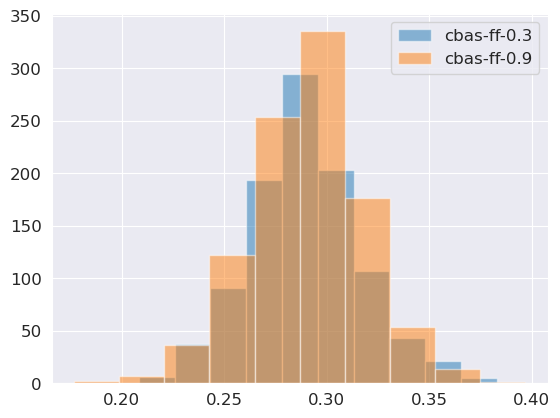

In [3]:
for name, data in name2designs.items():
    print(name, '{:.3f}, {:.3f}'.format(np.mean(data[1]), np.mean(data[2])))
    plt.hist(data[1], alpha=0.5, label=name)
plt.legend()

In [15]:
# vet all design labels
landscape = rna.RNABinding(binding_target_idx=[0], noise_sd=0)
n_label = 100
n_trial = 10

for i in range(3, n_trial):
    print(f'trial {i}')
    design_pkl_fname = '/data/wongfanc/rna-results/designs-n10k-092324-{}.pkl'.format(i)
    with open(design_pkl_fname, 'rb') as f:
        name2designdata = pickle.load(f)
        
    for name, (seq_n, y0_n, pred_n) in name2designdata.items():
        y1_n = landscape.get_fitness(seq_n[: n_label])
        diff = (np.mean(y0_n) - np.mean(y1_n)) / np.max([np.mean(y0_n), np.mean(y1_n)])
        print('  {}: old {:.3f}, new {:.3f} ({:.1f}% difference)'.format(
            name, np.mean(y0_n), np.mean(y1_n), 100 * diff))

trial 3
  cbas-ridge-0.1t19: old 0.296, new 0.294 (0.6% difference)
  cbas-ridge-0.2t19: old 0.301, new 0.301 (0.1% difference)
  cbas-ridge-0.3t19: old 0.304, new 0.305 (-0.3% difference)
  cbas-ridge-0.4t19: old 0.307, new 0.311 (-1.0% difference)
  cbas-ridge-0.5t19: old 0.316, new 0.319 (-1.2% difference)
  cbas-ridge-0.6t19: old 0.315, new 0.318 (-0.8% difference)
  cbas-ridge-0.7t19: old 0.330, new 0.330 (0.1% difference)
  cbas-ridge-0.8t19: old 0.354, new 0.361 (-1.9% difference)
  cbas-ridge-0.9t19: old 0.415, new 0.421 (-1.4% difference)
  vae-ridge: old 0.286, new 0.286 (-0.1% difference)
  dbas-ridge-0.1t19: old 0.322, new 0.323 (-0.3% difference)
  dbas-ridge-0.2t19: old 0.380, new 0.386 (-1.6% difference)
  adalead-ridge-0.5: old 0.345, new 0.329 (4.6% difference)
  adalead-ridge-0.45: old 0.347, new 0.330 (4.8% difference)
  adalead-ridge-0.4: old 0.349, new 0.332 (5.1% difference)
  adalead-ridge-0.35: old 0.351, new 0.334 (4.6% difference)
  adalead-ridge-0.3: old 0.35

  adalead-ff-0.45: old 0.349, new 0.333 (4.6% difference)
  adalead-ff-0.4: old 0.350, new 0.330 (5.8% difference)
  adalead-ff-0.35: old 0.352, new 0.335 (5.0% difference)
  adalead-ff-0.3: old 0.356, new 0.340 (4.6% difference)
  adalead-ff-0.25: old 0.361, new 0.342 (5.3% difference)
  adalead-ff-0.2: old 0.369, new 0.351 (4.9% difference)
  adalead-ff-0.15: old 0.375, new 0.354 (5.7% difference)
  adalead-ff-0.1: old 0.384, new 0.363 (5.5% difference)
  adalead-ff-0.05: old 0.385, new 0.369 (4.1% difference)
  adalead-ff-0.01: old 0.400, new 0.390 (2.6% difference)
  pex-ff: old 0.341, new 0.397 (-14.2% difference)
  biswas-ff-0.02: old 0.326, new 0.328 (-0.6% difference)
  biswas-ff-0.015: old 0.337, new 0.332 (1.2% difference)
  biswas-ff-0.01: old 0.355, new 0.355 (0.0% difference)
  biswas-ff-0.005: old 0.380, new 0.382 (-0.6% difference)
  cbas-cnn-0.1: old 0.299, new 0.302 (-1.0% difference)
  cbas-cnn-0.2: old 0.305, new 0.308 (-0.8% difference)
  cbas-cnn-0.3: old 0.306, ne

SystemError: <built-in function duplexfold> returned a result with an error set